In [1458]:
pip install stepwise-regression

Note: you may need to restart the kernel to use updated packages.


In [1470]:
from stepwise_regression.step_reg import backward_regression, forward_regression

In [1569]:
import geopandas as gpd
from shapely import wkt #to find centroid of a polygon
from zipfile import ZipFile
from shapely.geometry import Point
import folium
from statsmodels.formula.api import ols, glm
from scipy.stats import entropy
import sklearn.linear_model

# Table of Contents<a name='TOC' />
<a href=#bookmark0>0. Import libaries and data respectively </a>

<a href=#bookmark0.1>0.1 Some Sanity Checks on the Dataset </a>

<a href=#extract_historical_cols><font color='blue'>Function to extract external columns that are historical (e.g. extract <code>median_rent</code> from <code>2000_median_rent 2000_median_rent, ... , etc</code>)</font> </a>

<a href=#bookmark0.1.1>0.1.1 <font color='green'> Typecast population into floats </font></a>

<a href=#bookmark0.1.2>0.1.2 <font color='green'> Typecast parking spaces into ints </font></a>

<a href=#bookmark0.1.3>0.1.3 <font color='green'>Sanity check results, packaged into a function. Skip to this if don't want to see all above </font></a>

<a href=#bookmark1>1. *Split the data first* and use *stratified* sampling</a>

<a href=#bookmark2>2. Begin some EDA on the stratified training data</a>

<a href=#bookmark2.0>2.0 Remark before starting EDA</a> 

<a href=#bookmark2.1>2.1 Pairwise plot for internal features</a>

<a href=#sz_internal_continuous_training_cols><font color='blue'>Functions to standardize internal columns and external columns in training data, also returns appropriate statistics. Also can standardize entire dataset</font> </a>

<a href=#bookmark2.2>2.2 Pairwise plot/correlation plot for external features</a>


<a href=#bookmark3>3. **First Model (OLS with regularization)**</a>

<a href=#OH_encoder><font color='blue'>Function to one hot encode categorical variables. </font></a>

<a href=#std_and_OH><font color='blue'>Function to preprocess vars; so far: standardize + OH encode </font></a>

<a href=#transform_test_data><font color='blue'>Function to "transform"/preprocess test data </font></a>

<a href=#bookmark3.1>3.1 Full model without any feature engineering, just standardizing continuous numerical vars and one hot encode nominal vars</a>


<a href=#bookmark3.1.1>3.1.1 CV for choosing hyperparameters for regularization</a>

<a href=#ols_formula_object><font color='blue'>Function to make formula object to be passed to statsmodels' OLS model</font></a>

<a href=#elasticNetHyp><font color='blue'>Function: hyperparameter tuning for penalized regression (elastic net): which penalty method (i.e. alpha) produces the somewhat optimal model? </font> </a>

<a href=#K-fold-CV><font color='blue'> Function for K-fold CV</font> </a>

<a href=#bookmark3.1.2>3.1.2 K-fold CV</a>

<a href=#bookmark3.1.2>3.1.3 Learning Curve</a>




<a href=#residualPlotFunc><font color='blue'>Function for residual plot.</font> </a>

<a href=#bookmark4>4. Further Feature Engineering</a>

<a href=#bookmark4.1>4.1 Instead of retaining historical external variables as is, obtain the <code>TIME_LAG</code>-year increase for each of them to reduce multicollinearity</a>

<a href=#bookmark4.2>4.2 Pairwise plot of internal features for any possible transformation</a>

<a href=#bookmark4.3>4.3 Current decision to feature engineer: </a>

<a href=#bookmark4.4>4.4 **Fitting Model** given the feature engineerings [1) time lag for historical external vars 2) transformation for distance to cbd variable 3) log response variable] + evaluating the model + diagnostics</a>

<a href=#bookmark4.5>4.5 **Fit the same model above, but without the historical external variables** + evaluating the model </a>


# Geospatial Code 

In [1025]:
def preproc_shapefile(vic_shapefile):
    
    #casefold into lower cases 
    vic_shapefile['LOC_NAME'] = vic_shapefile['LOC_NAME'].str.lower()
        
    #remove duplicates
    vic_shapefile_no_duplicates = vic_shapefile.loc[vic_shapefile['LOC_NAME'].drop_duplicates().index,:]
    
    vic_shapefile['centroid'] = vic_shapefile['geometry'].map(
    lambda polygon: 
        wkt.loads( #after finding centroid, need to re-parse this back into a Point object
            wkt.loads(str(polygon)).centroid.wkt #need str object to find centroid
        )
    )
    
    return vic_shapefile
    
    

# <font color='red'> CHANGE <code>vic_localities.shp</code> to <code>vic_shapefile_zipped.zip</code> </font>

In [1047]:
vic_sf = gpd.read_file('../data/raw/vic_shapefile_zipped.zip')
vic_shapefile_no_duplicates = preproc_shapefile(vic_sf)

In [1032]:
def geopandas_plotting(rental_df, 
                       sf=vic_shapefile_no_duplicates, 
                       legend_name='Distribution of prices across suburbs', 
                       col_to_be_plot='cost_text',
                       save=False,
                       saved_map_name='',
                       map_format='html'):
    
    """
    Helper function to plot an aggregated metric by suburb
    (e.g. taking the mean of rental prices per suburb)
    
    Arguments:
    1. rental_df: df containing suburb columns and an aggregated
    metric corresponding to each suburb 
    
    E.g. columns may look like SUBURB || MEAN OF RENTAL PRICES
    
    2. sf: preprocessed victoria shapefile using the function above
     - Already provided with the preprocessed shapefile as default argument, 
       no need to pass preprocessed shapefile anymore!
    
    3. legend_name: legend text to appear on bottom right of the folium map
    
    4. col_to_be_plot: which numeric col to be plotted 
    
    
    """
    
    
    #if not specifying the legend name then the default one 
    #here will be used. 
    if not legend_name:
        legend_name = f'Distribution of {col_to_be_plot} across suburbs'

    #sf: shapefile of all victorian suburbs (vic_shapefile_no_duplicates)

    #need to have shapefile and zone lookups (in this case, suburb) before plotting
    
    

    # Convert the geometry shaape to to latitude and longitude
    # Please attribute this if you are using it
    sf['geometry'] = sf['geometry'].to_crs("+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs")

    #gdf = rental_df merged with sf to obtain the geometry for each subrub
    gdf = rental_df.merge(sf[['LOC_NAME', 'geometry']],
            left_on = 'suburb',
            right_on = 'LOC_NAME',
            how='inner').\
            drop(columns=['LOC_NAME'])

    #convert the merged rental_df to a GeoDataFrame 
    gdf = gpd.GeoDataFrame(gdf)

    # combine geopandas with folium to create visualistion,  
    # but still need geojson and folium map object

    #note: drop duplicates because initiallly there are multiple properties in a suburb
    #but to find the geometry we don't require all duplicates. 
    geoJSON = gdf[['suburb', 'geometry']].drop_duplicates('suburb').to_json()


    # df_toplot = rental_df.copy()
    # df_toplot = df_toplot \
    # .merge(gdf[['LocationID', 'geometry']], left_on='PULocationID', right_on='LocationID') \
    # .drop('LocationID', axis=1) #drop duplicate LocationID column

    # print(df_toplot)

    m = folium.Map(location=[-37.7829335, 144.9575056])

    # refer to the folium documentations on more information on how to plot aggregated data.
    c = folium.Choropleth(
        geo_data=geoJSON, # geoJSON 
        name='choropleth', # name of plot
        data=gdf, # data source
        columns=['suburb',col_to_be_plot], # the columns required
        key_on='properties.suburb', # this is from the geoJSON's properties
        fill_color='YlOrRd', # color scheme
        nan_fill_color='black',
        legend_name=legend_name
    )

    c.add_to(m)


    display(m)
    
    if save == True:
        m.save(f'../plots/{saved_map_name}.{map_format}')


# 0. Import libaries and data respectively<a name='bookmark0' />

<a href=#TOC>Back to ToC</a>

In [1]:
from statsmodels.formula.api import ols, glm
import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.preprocessing import StandardScaler
from glmnet import ElasticNet
import numpy as np

In [2]:
import pandas as pd
final_data = pd.read_csv('../data/curated/Final_Merged_Dataset.csv')

In order for geospatial code to work, all suburbs in the merged dataset used for modelling have to exist in the vic shapefile.

In [1031]:
set(final_data['suburb'].unique()) - set(vic_shapefile_no_duplicates['LOC_NAME'])

set()

## <font color='red'>Some fixes, should there be necessary</font>

In [3]:
final_data

cost_text      suburb  bedrooms  bathrooms  parking_spaces  \
0         680.0  hughesdale         3          2             2.0   
1         475.0  hughesdale         2          1             1.0   
2         550.0  hughesdale         3          1             2.0   
3         500.0  hughesdale         2          1             2.0   
4         400.0  hughesdale         2          1             1.0   
...         ...         ...       ...        ...             ...   
5685      450.0   doncaster         2          2             1.0   
5686      610.0   doncaster         3          2             2.0   
5687      720.0   doncaster         4          2             2.0   
5688      430.0   doncaster         2          2             1.0   
5689      730.0   doncaster         3          2             2.0   

      nearest_hospital  nearest_train_station  distance_to_cbd  \
0               3.6709                 1.3443          18.9780   
1               5.1099                 0.6205          17.5619   
2               3.1582                 2.2726          19.4758   
3               5.2768                 1.0049          17.1311   
4               4.5390                 1.1504          18.2156   
...                ...                    ...              ...   
5685            2.3739                22.1588          17.8709   
5686            2.8003                22.5852          17.8021   
5687            2.3061                21.7854          18.1204   
5688            2.2397                22.0246          17.8975   
5689            2.3070                22.0919          17.1354   

      nearest_school  2000_median_rent  ...  2012_unemployment_rate  \
0             0.3622             170.0  ...                     5.4   
1             1.2980             170.0  ...                     5.4   
2             0.4716             170.0  ...                     5.4   
3             0.8671             170.0  ...                     5.4   
4             0.8428             170.0  ...                     5.4   
...              ...               ...  ...                     ...   
5685          0.7789             230.0  ...                     6.2   
5686          0.3681             230.0  ...                     6.2   
5687          0.5335             230.0  ...                     6.2   
5688          0.6186             230.0  ...                     6.2   
5689          0.7121             230.0  ...                     6.2   

      2013_unemployment_rate  2014_unemployment_rate  2015_unemployment_rate  \
0                        6.2                     5.9                     4.7   
1                        6.2                     5.9                     4.7   
2                        6.2                     5.9                     4.7   
3                        6.2                     5.9                     4.7   
4                        6.2                     5.9                     4.7   
...                      ...                     ...                     ...   
5685                     8.6                     9.4                     8.5   
5686                     8.6                     9.4                     8.5   
5687                     8.6                     9.4                     8.5   
5688                     8.6                     9.4                     8.5   
5689                     8.6                     9.4                     8.5   

      2016_unemployment_rate  2017_unemployment_rate  2018_unemployment_rate  \
0                        4.7                     4.9                     4.4   
1                        4.7                     4.9                     4.4   
2                        4.7                     4.9                     4.4   
3                        4.7                     4.9                     4.4   
4                        4.7                     4.9                     4.4   
...                      ...                     ...                     ...   
5685                  

## 0.1 Some sanity checks on the dataset. <a name='bookmark0.1' />

<a href=#TOC>Back to ToC</a>

In [4]:
final_data.dtypes[
    final_data.dtypes != 'float64'
]

suburb             object
bedrooms            int64
bathrooms           int64
population_2001     int64
population_2002     int64
population_2003     int64
population_2004     int64
population_2005     int64
population_2006     int64
population_2007     int64
population_2008     int64
population_2009     int64
population_2010     int64
population_2011     int64
population_2012     int64
population_2013     int64
population_2014     int64
population_2015     int64
population_2016     int64
population_2017     int64
population_2018     int64
population_2019     int64
population_2020     int64
population_2021     int64
dtype: object

1. Confirm that there's no missing instances

In [5]:
print('Num of missing instances:',
      final_data.isna().sum(axis=1)[final_data.isna().sum(axis=1).gt(0)].nunique()
)

Num of missing instances: 0


2. make sure data types are compatible (e.g. if ordinal, then int would be suitable)


- 2.1 extract unique variables that were recorded on a specific time period (that contains years)
    - such cols can be in the beginning e.g. 2014_median_rent or end: population_density_2014 
    - hence why the pattern ([A-Za-z_]*) on both ends of the pattern 
    - consequence: the match will return a tuple (e.g. first one will return ('', 'median_rent') and second one will return ('population_density_', '')). 

In [1182]:
final_data

cost_text      suburb  bedrooms  bathrooms  parking_spaces  \
0         680.0  hughesdale         3          2               2   
1         475.0  hughesdale         2          1               1   
2         550.0  hughesdale         3          1               2   
3         500.0  hughesdale         2          1               2   
4         400.0  hughesdale         2          1               1   
...         ...         ...       ...        ...             ...   
5685      450.0   doncaster         2          2               1   
5686      610.0   doncaster         3          2               2   
5687      720.0   doncaster         4          2               2   
5688      430.0   doncaster         2          2               1   
5689      730.0   doncaster         3          2               2   

      nearest_hospital  nearest_train_station  distance_to_cbd  \
0               3.6709                 1.3443          18.9780   
1               5.1099                 0.6205          17.5619   
2               3.1582                 2.2726          19.4758   
3               5.2768                 1.0049          17.1311   
4               4.5390                 1.1504          18.2156   
...                ...                    ...              ...   
5685            2.3739                22.1588          17.8709   
5686            2.8003                22.5852          17.8021   
5687            2.3061                21.7854          18.1204   
5688            2.2397                22.0246          17.8975   
5689            2.3070                22.0919          17.1354   

      nearest_school  2000_median_rent  ...  2012_unemployment_rate  \
0             0.3622             170.0  ...                     5.4   
1             1.2980             170.0  ...                     5.4   
2             0.4716             170.0  ...                     5.4   
3             0.8671             170.0  ...                     5.4   
4             0.8428             170.0  ...                     5.4   
...              ...               ...  ...                     ...   
5685          0.7789             230.0  ...                     6.2   
5686          0.3681             230.0  ...                     6.2   
5687          0.5335             230.0  ...                     6.2   
5688          0.6186             230.0  ...                     6.2   
5689          0.7121             230.0  ...                     6.2   

      2013_unemployment_rate  2014_unemployment_rate  2015_unemployment_rate  \
0                        6.2                     5.9                     4.7   
1                        6.2                     5.9                     4.7   
2                        6.2                     5.9                     4.7   
3                        6.2                     5.9                     4.7   
4                        6.2                     5.9                     4.7   
...                      ...                     ...                     ...   
5685                     8.6                     9.4                     8.5   
5686                     8.6                     9.4                     8.5   
5687                     8.6                     9.4                     8.5   
5688                     8.6                     9.4                     8.5   
5689                     8.6                     9.4                     8.5   

      2016_unemployment_rate  2017_unemployment_rate  2018_unemployment_rate  \
0                        4.7                     4.9                     4.4   
1                        4.7                     4.9                     4.4   
2                        4.7                     4.9                     4.4   
3                        4.7                     4.9                     4.4   
4                        4.7                     4.9                     4.4   
...                      ...                     ...                     ...   
5685                  

In [6]:
def extract_col_with_historical_values(findall_raw_match):
    
    #re.findall will return matches as a list
    findall_match_tuple = findall_raw_match[0]
    
    #as mentioned above, given 2 capture groups then 
    #match will be returned as a tuple. 
    if findall_match_tuple[0] == '':
        return findall_match_tuple[1]
    return findall_match_tuple[0]

cols_with_historical_vals = pd.Series(final_data.columns)[
        pd.Series(final_data.columns).str.contains('\d')
    ].\
        str.findall('([A-Za-z_]*)[\d_]+([A-Za-z_]*)').\
        map(lambda x: extract_col_with_historical_values(x)).unique()

cols_with_historical_vals


array(['median_rent', 'annual_income', 'population_',
       'population_density_', 'immigration', 'unemployment_rate'],
      dtype=object)

<font color='blue'>Function to extract external columns that are historical (e.g. extract <code>median_rent</code> from <code>2000_median_rent 2000_median_rent, ... , etc</code>)</font> <a name='extract_historical_cols' />

In [321]:
def extract_col_with_historical_values_from_df(final_data):
    
    cols_with_historical_vals = pd.Series(final_data.columns)[
        pd.Series(final_data.columns).str.contains('\d')
    ].\
        str.findall('([A-Za-z_]*)[\d_]+([A-Za-z_]*)').\
        map(lambda x: extract_col_with_historical_values(x)).unique()
    
    return cols_with_historical_vals

Do columns that contain numbers only STRICTLY encopass the variables above?

In [7]:
def is_col_containing_nums_not_periodic(raw_col_name, cols_with_historical_vals):
    
    for col in cols_with_historical_vals:
        if col in raw_col_name:
            return False
    return True

pd.Series(final_data.columns)[
        pd.Series(final_data.columns).str.contains('\d')
    ].map(lambda x: is_col_containing_nums_not_periodic(x, cols_with_historical_vals)).sum()

0

Yes, all columns with numbers are columns whose values were recorded prior to 2022.
- So columns containing numbers <=> columns whose values are historical

Now check: are they all floats?

In [8]:
historical_cols_and_dtypes = final_data.dtypes[
    
    final_data.dtypes.index.isin(
        
        pd.Series(final_data.columns)[
            pd.Series(final_data.columns).str.contains('\d')
        ]
    )
]

In [9]:
historical_cols_and_dtypes[
    historical_cols_and_dtypes != 'float64'
]

population_2001    int64
population_2002    int64
population_2003    int64
population_2004    int64
population_2005    int64
population_2006    int64
population_2007    int64
population_2008    int64
population_2009    int64
population_2010    int64
population_2011    int64
population_2012    int64
population_2013    int64
population_2014    int64
population_2015    int64
population_2016    int64
population_2017    int64
population_2018    int64
population_2019    int64
population_2020    int64
population_2021    int64
dtype: object

## 0.1.1 <font color='green'> Typecast population into floats </font><a name='bookmark0.1.1' />

<a href=#TOC>Back to ToC</a>

While population cannot be floats theoretically their values are not bounded. <font color='green'>So we can treat them as numeric variables</font>

In [10]:
final_data.loc[:, final_data.columns.str.contains('population')] =\
        final_data.loc[:, final_data.columns.str.contains('population')].astype('float64')

3. What about the columns that are not historical?

In [11]:
final_data.dtypes[
    ~final_data.dtypes.index.isin(historical_cols_and_dtypes.index)
]

cost_text                float64
suburb                    object
bedrooms                   int64
bathrooms                  int64
parking_spaces           float64
nearest_hospital         float64
nearest_train_station    float64
distance_to_cbd          float64
nearest_school           float64
dtype: object

Hmm.. all is well, except, isn't parking spaces ordinal?

In [12]:
final_data['parking_spaces'].unique()

array([2., 1., 3., 4., 5., 6.])

Yeah, only a finite number of values available. <font color='green'> So need to typecast them into ints</font>

## 0.1.2 <font color='green'> Typecast parking spaces into ints </font><a name='bookmark0.1.2' />

<a href=#TOC>Back to ToC</a>

In [13]:
final_data.loc[:,'parking_spaces'] = final_data.loc[:,'parking_spaces'].astype('int64')

## 0.1.3 <font color='green'>Sanity check results, packaged into a function. Skip to this if don't want to see all above </font><a name='bookmark0.1.3' />

<a href=#TOC>Back to ToC</a>

In [14]:
def additional_typecasts(final_data):
    
    #typecast population into floats. Conventionally we'd treat
    #ints for ordinal variables but # of values in population is 
    #unbounded, so maybe more suitable to be ints 
    
    final_data.loc[:, final_data.columns.str.contains('population')] =\
        final_data.loc[:, final_data.columns.str.contains('population')].astype('float64')
    
    #typecast parking spaces to int (is a ordinal variable); can only take values 1-6
    final_data.loc[:,'parking_spaces'] = final_data.loc[:,'parking_spaces'].astype('int64')
    
    return final_data

Now, we're good to jump into modelling!

# 1. Since there are many variables, need to have a look at them first --> need some training data for doing EDA. So **split the data first** <a name='bookmark1' />

<a href=#TOC>Back to ToC</a>

Also, use stratified sampling to ensure that we every suburb is roughly equally represented in the training data.

In [459]:
def sample_df(df, frac=0.5):
    
    """Sampling 100*frac % of the
    dataframe df. If num rows of 
    df not enough we just return the data
    frame. 
    
    Usually used when want to stratify sampling 
    100*frac% of instances per suburb 
    """
    
    #if num rows of df is not enough to be sampled
    #based on the frac specified
    if df.shape[0] * frac < 1:
        return df
    
    else:
        return df.sample(frac=frac,
                        random_state=1)


In [460]:
def stratify_sampling_unif(final_data, frac=0.5):
    
    """Split the full data into training 
    and testing data by stratify sampling that 
    makes sure each suburb gets its 100*frac% 
    of instances sampled. """
    
    #sample 100*frac% of instances per suburb 
    train_data = final_data.groupby(
                    'suburb',group_keys=False).apply(
                            lambda x: sample_df(x, 0.5)
                        )
    #obtain the test data
    test_data = final_data[
        ~final_data.index.isin(train_data.index)
    ]

    return train_data, test_data

In [528]:
train_data_strat, test_data_strat = stratify_sampling_unif(final_data)

# 2. Begin some EDA on the stratified training data <a name='bookmark2' />

<a href=#TOC>Back to ToC</a>

## 2.0 Remark before starting EDA <a name='bookmark2.0' />

<a href=#TOC>Back to ToC</a>

A natural thing to do is to do a pairwise plot. But we have 98 columns in total.. 

But we can do several pairwise plots:

1. For columns that are historical, we'd expect to be correlated overtime. 
    - E.g. median rent in 2000 will be somewhat correlated to median rent in 2001, and up to whatever year it is recorded. Same thing for others.
    - So for each of <code>['median rent', 'annual income', 'population','population density','immigration','unemployment rate']</code> we might do a pairwise plot. 
        - Then for each of them we might feature engineer: take the annual difference (e.g. so for median rent, cols will be: <code>['annual increase from 2000', 'annual increase from 2002', .... ]</code>, hoping that this will reduce multicollinearity.
    
    
2. As for the other columns (i.e. **INTERNAL** features) we can also do a pairwise plot (only 6 columns roughly, excluding suburbs)

# 2.1 Pairwise plot for internal features <a name='bookmark2.1' />

<a href=#TOC>Back to ToC</a>

<font color='blue'>Function to standardize internal columns in training data, also returns appropriate statistics</font> <a name='sz_internal_continuous_training_cols' />

In [22]:
train_data_internal_feats.dtypes[
   train_data_internal_feats.dtypes == 'float64' 
]

cost_text                float64
nearest_hospital         float64
nearest_train_station    float64
distance_to_cbd          float64
nearest_school           float64
dtype: object

In [23]:
def standardize_continuous_cols_internal_feats(train_data_internal_feats):
    """
    Standardizes continuous INTERNAL columns in the 
    TRAINING set that only contains the INTERNAL columns.
    
    Returns a tuple, containing: 
    1. the standardized training data with internal columns
    
    2. means and standard deviations of each such column 
    to be transformed to the holdout set. 
    
    """
    #sanity check to not mutate the original data
    train_data_internal_feats_output = train_data_internal_feats.copy()
    
    
    continuous_internal_cols = train_data_internal_feats.dtypes[
        train_data_internal_feats.dtypes == 'float64' 
    ].index
    
    #exclude the response from being standardized
    continuous_internal_cols = list(set(continuous_internal_cols) - set(['cost_text']))
    
    #means and std of all internal continuous columns
    continuous_cols_statistics = train_data_internal_feats.loc[:,continuous_internal_cols].agg(['mean','std'])
    
    train_data_internal_feats_output.loc[:,continuous_internal_cols] =\
            stats.zscore(
                    train_data_internal_feats_output.loc[:,continuous_internal_cols]
            )
    
    return train_data_internal_feats_output, continuous_cols_statistics


In [24]:
def standardize_continuous_cols_external_feats(train_data_external_feats):
    """
    Standardizes continuous EXTERNAL columns in the 
    TRAINING set that only contains the EXTERNAL columns.
    
    Returns a tuple, containing: 
    1. the standardized training data with external columns
    
    2. means and standard deviations of each such column 
    to be transformed to the holdout set. 
    
    """
    #sanity check to not mutate the original data
    train_data_external_feats_output = train_data_external_feats.copy()
    
    
    continuous_external_cols = train_data_external_feats.dtypes[
        train_data_external_feats.dtypes == 'float64' 
    ].index
    
    #exclude the response from being standardized
    continuous_external_cols = list(set(continuous_external_cols) - set(['cost_text']))
    
    #means and std of all internal continuous columns
    continuous_cols_statistics = train_data_external_feats.loc[:,continuous_external_cols].agg(['mean','std'])
    
    train_data_external_feats_output.loc[:,continuous_external_cols] =\
            stats.zscore(
                    train_data_external_feats_output.loc[:,continuous_external_cols]
            )
    
    return train_data_external_feats_output, continuous_cols_statistics


In [25]:
def standardize_all_continuous_numeric_vars(train_data):
    """
    Standardizes ALL numeric columns
    
    Returns a tuple, containing: 
    1. the standardized continuous cols in the training data 
    
    2. means and standard deviations of each such column 
    to be transformed to the holdout set. 
    
    """
    
    train_standardized_output = train_data.copy()
    
    continuous_cols = train_standardized_output.dtypes[
        train_standardized_output.dtypes == 'float64'
    ].index
    
    #exclude the response from being standardized
    continuous_cols = list(set(continuous_cols) - set(['cost_text']))
    
    #means and std of all internal continuous columns
    continuous_cols_statistics = train_standardized_output.loc[:,continuous_cols].agg(['mean','std'])
    
    #standardize each numeric column
    train_standardized_output.loc[:,continuous_cols] =\
            stats.zscore(
                    train_standardized_output.loc[:,continuous_cols]
            )
    return train_standardized_output, continuous_cols_statistics
    

In [26]:
standardize_training_internal_feats_data = standardize_continuous_cols_internal_feats(train_data_internal_feats)
train_internal_standardized = standardize_training_internal_feats_data[0]

In [27]:
train_internal_standardized

cost_text      suburb  bedrooms  bathrooms  parking_spaces  \
3929      580.0  abbotsford         2          2               1   
3923      600.0  abbotsford         2          1               1   
3934      575.0  abbotsford         2          2               1   
3916      420.0  abbotsford         1          1               1   
3932      460.0  abbotsford         2          1               1   
...         ...         ...       ...        ...             ...   
1906      265.0  yarraville         2          1               1   
1858      625.0  yarraville         3          1               1   
1897      540.0  yarraville         3          1               1   
1878      445.0  yarraville         2          1               1   
1866      370.0  yarraville         2          1               1   

      nearest_hospital  nearest_train_station  distance_to_cbd  nearest_school  
3929         -0.243919              -0.340530        -0.527830        0.371941  
3923         -0.373056              -0.481990        -0.547348        0.712044  
3934         -0.234690              -0.330792        -0.526435       -0.044351  
3916         -0.235646              -0.331801        -0.526581       -0.057150  
3932         -0.278977              -0.247277        -0.533130        0.139872  
...                ...                    ...              ...             ...  
1906         -0.253343              -0.351655        -0.445760        0.271068  
1858         -0.335625              -0.347764        -0.419917       -0.488527  
1897         -0.226591              -0.163155        -0.410896        0.076788  
1878         -0.351063              -0.371497        -0.460595        0.409120  
1866         -0.312341              -0.411923        -0.454886       -0.070864  

[2844 rows x 9 columns]

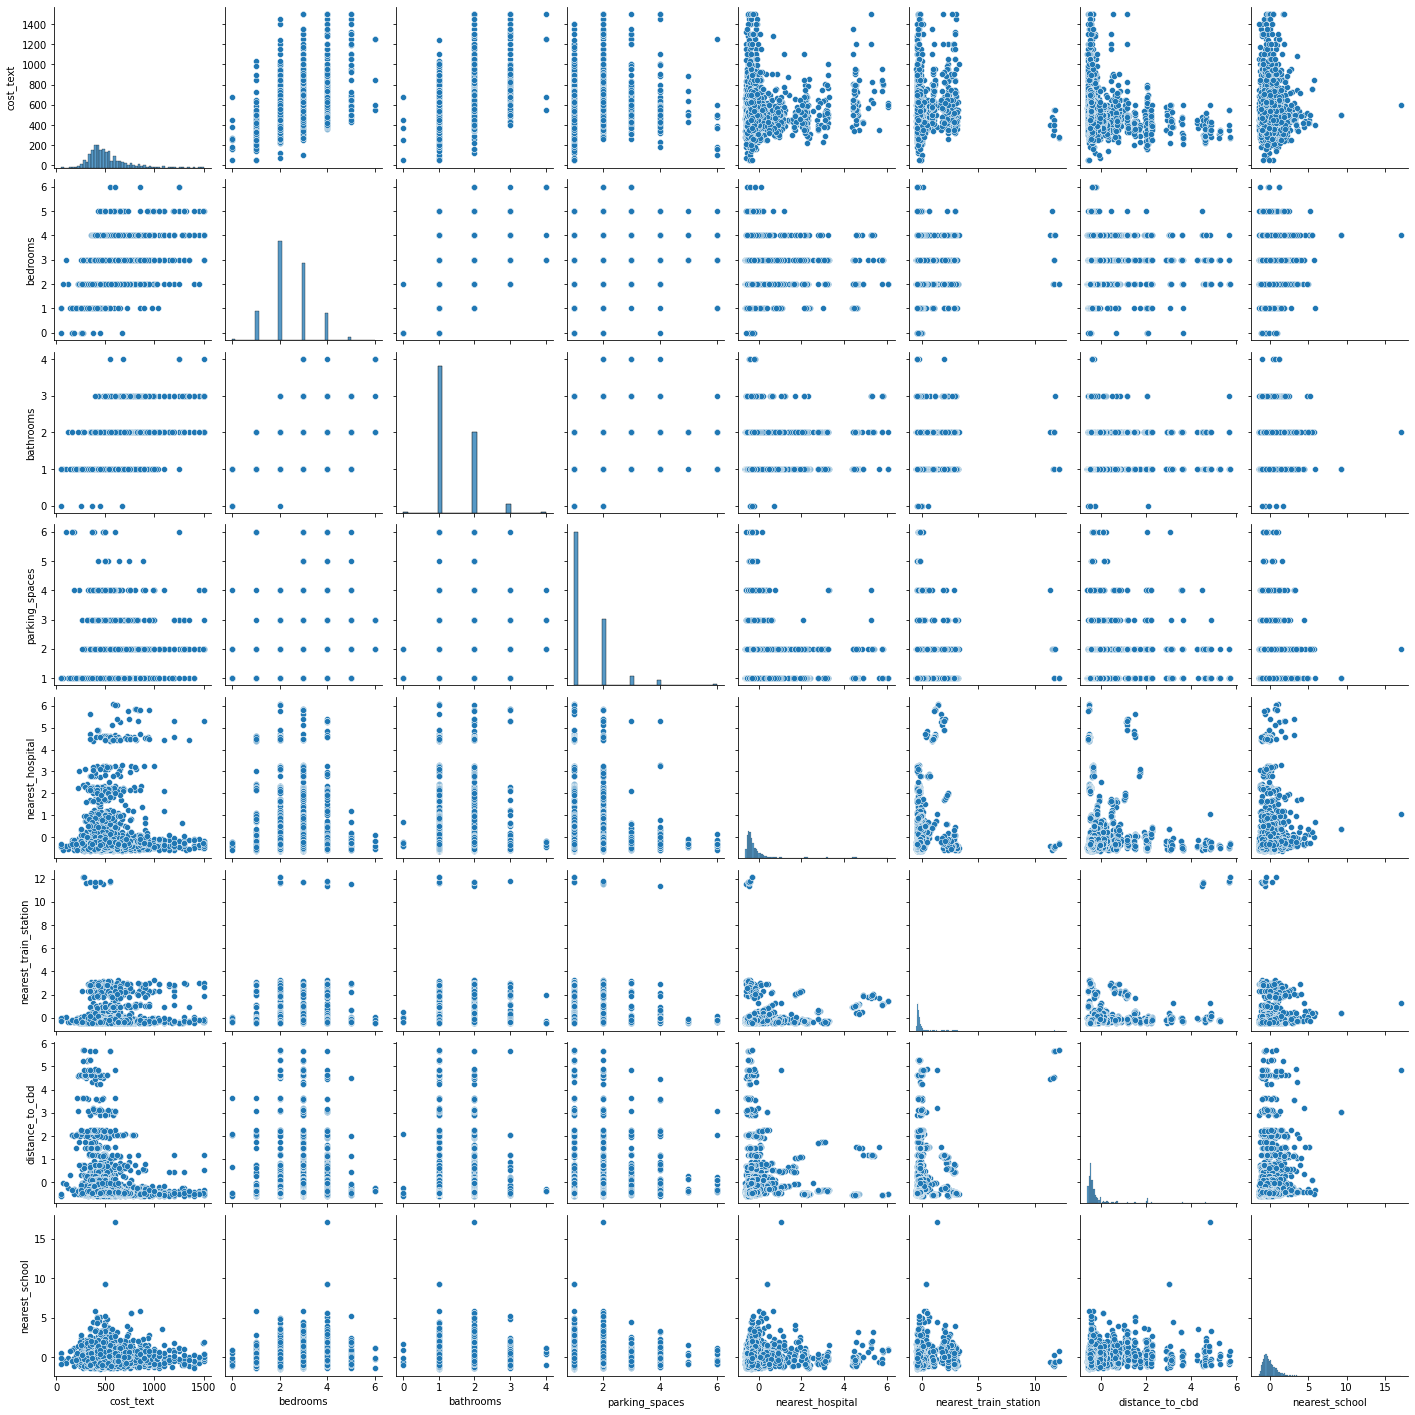

In [28]:
sns.pairplot(
    train_internal_standardized.drop(columns='suburb')
)

## <font color='red'>It seems that there's a somewhat evident inverse relationship between distance to cbd and cost_text</font> However, I will fit the full model first as a "baseline" and then attempt some feature engineering to see if there's any difference or not.

<AxesSubplot:>

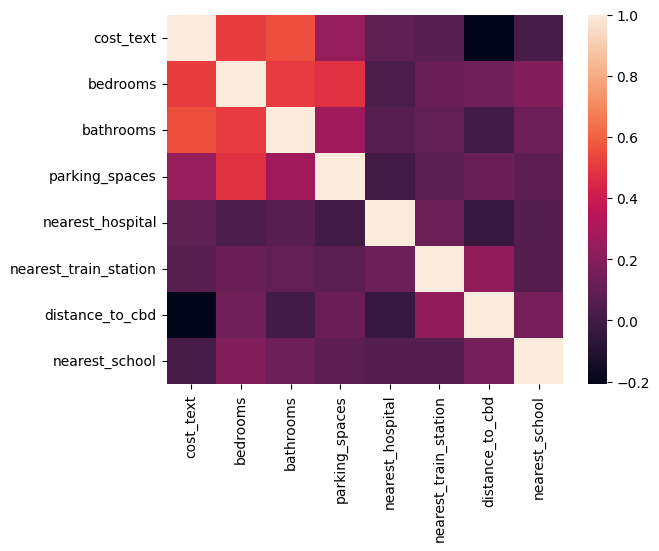

In [29]:
sns.heatmap(train_internal_standardized.drop(columns='suburb').corr())

# 2.2 Pairwise plot for external features <a name='bookmark2.2' />

<a href=#TOC>Back to ToC</a>

In [30]:
train_data_external_feats

cost_text  2000_median_rent  2001_median_rent  2002_median_rent  \
3929      580.0             240.0             250.0             260.0   
3923      600.0             240.0             250.0             260.0   
3934      575.0             240.0             250.0             260.0   
3916      420.0             240.0             250.0             260.0   
3932      460.0             240.0             250.0             260.0   
...         ...               ...               ...               ...   
1906      265.0             180.0             195.0             200.0   
1858      625.0             180.0             195.0             200.0   
1897      540.0             180.0             195.0             200.0   
1878      445.0             180.0             195.0             200.0   
1866      370.0             180.0             195.0             200.0   

      2003_median_rent  2004_median_rent  2005_median_rent  2006_median_rent  \
3929             265.0             275.0             275.0             300.0   
3923             265.0             275.0             275.0             300.0   
3934             265.0             275.0             275.0             300.0   
3916             265.0             275.0             275.0             300.0   
3932             265.0             275.0             275.0             300.0   
...                ...               ...               ...               ...   
1906             210.0             220.0             230.0             250.0   
1858             210.0             220.0             230.0             250.0   
1897             210.0             220.0             230.0             250.0   
1878             210.0             220.0             230.0             250.0   
1866             210.0             220.0             230.0             250.0   

      2007_median_rent  2008_median_rent  ...  2012_unemployment_rate  \
3929             350.0             385.0  ...                     5.3   
3923             350.0             385.0  ...                     5.3   
3934             350.0             385.0  ...                     5.3   
3916             350.0             385.0  ...                     5.3   
3932             350.0             385.0  ...                     5.3   
...                ...               ...  ...                     ...   
1906             280.0             320.0  ...                     4.4   
1858             280.0             320.0  ...                     4.4   
1897             280.0             320.0  ...                     4.4   
1878             280.0             320.0  ...                     4.4   
1866             280.0             320.0  ...                     4.4   

      2013_unemployment_rate  2014_unemployment_rate  2015_unemployment_rate  \
3929                     5.5                     5.4                     4.5   
3923                     5.5                     5.4                     4.5   
3934                     5.5                     5.4                     4.5   
3916                     5.5                     5.4                     4.5   
3932                     5.5                     5.4                     4.5   
...                      ...                     ...                     ...   
1906                     3.7                     3.9                     3.9   
1858                     3.7                     3.9                     3.9   
1897                     3.7                     3.9                     3.9   
1878                     3.7                     3.9                     3.9   
1866                     3.7                     3.9                     3.9   

      2016_unemployment_rate  2017_unemployment_rate  2018_unemployment_rate  \
3929                     3.4                     4.1                     2.9   
3923                     3.4                     4.1                     2.9   
3934                     3.4                     4.1                     2.9   
3916      

Extract *unique* variable names, excluding the year, that were taken in the past.

In [31]:
def extract_external_col_with_historical_values(data_external_feats):
    
    """Extract all external columns that were taken in
    the past and have numbers (years, in particular) in the 
    column names. """
    
    def extract_match_with_historical_values(findall_raw_match):
    
        #re.findall will return matches as a list
        findall_match_tuple = findall_raw_match[0]

        #as mentioned above, given 2 capture groups then 
        #match will be returned as a tuple. 
        if findall_match_tuple[0] == '':
            return findall_match_tuple[1]
        return findall_match_tuple[0]
    
    external_cols_with_historical_vals = pd.Series(data_external_feats.columns)[
        pd.Series(data_external_feats.columns).str.contains('\d')
    ].\
        str.findall('([A-Za-z_]*)[\d_]+([A-Za-z_]*)').\
        map(lambda x: extract_match_with_historical_values(x)).unique()
    
    return external_cols_with_historical_vals
    

In [32]:
unique_external_vals_historical = extract_external_col_with_historical_values(train_data_external_feats)

In [33]:
unique_external_vals_historical

array(['median_rent', 'annual_income', 'population_',
       'population_density_', 'immigration', 'unemployment_rate'],
      dtype=object)

In [34]:
def extract_cost_text_and_historical_var_in_external_train(train_data_external_feats, col_name):
    
    condition1 = train_data_external_feats.columns.str.contains(col_name)
                            
    condition2 = train_data_external_feats.columns.str.contains('cost_text')
    
    return train_data_external_feats.loc[:, (condition1 | condition2)].copy()

Plot correlations between response and annual median rents

In [35]:
standardize_continuous_cols_external_feats(
    extract_cost_text_and_historical_var_in_external_train(train_data_external_feats, 'median_rent')
)[0]

cost_text  2000_median_rent  2001_median_rent  2002_median_rent  \
3929      580.0          0.900527          0.832148          0.908782   
3923      600.0          0.900527          0.832148          0.908782   
3934      575.0          0.900527          0.832148          0.908782   
3916      420.0          0.900527          0.832148          0.908782   
3932      460.0          0.900527          0.832148          0.908782   
...         ...               ...               ...               ...   
1906      265.0         -0.328019         -0.236891         -0.298320   
1858      625.0         -0.328019         -0.236891         -0.298320   
1897      540.0         -0.328019         -0.236891         -0.298320   
1878      445.0         -0.328019         -0.236891         -0.298320   
1866      370.0         -0.328019         -0.236891         -0.298320   

      2003_median_rent  2004_median_rent  2005_median_rent  2006_median_rent  \
3929          0.882062          0.977504          0.810579          0.929286   
3923          0.882062          0.977504          0.810579          0.929286   
3934          0.882062          0.977504          0.810579          0.929286   
3916          0.882062          0.977504          0.810579          0.929286   
3932          0.882062          0.977504          0.810579          0.929286   
...                ...               ...               ...               ...   
1906         -0.247427         -0.172717         -0.122803         -0.017047   
1858         -0.247427         -0.172717         -0.122803         -0.017047   
1897         -0.247427         -0.172717         -0.122803         -0.017047   
1878         -0.247427         -0.172717         -0.122803         -0.017047   
1866         -0.247427         -0.172717         -0.122803         -0.017047   

      2007_median_rent  2008_median_rent  ...  2012_median_rent  \
3929          1.152513          1.046405  ...          1.107854   
3923          1.152513          1.046405  ...          1.107854   
3934          1.152513          1.046405  ...          1.107854   
3916          1.152513          1.046405  ...          1.107854   
3932          1.152513          1.046405  ...          1.107854   
...                ...               ...  ...               ...   
1906          0.015329          0.092143  ...          0.094367   
1858          0.015329          0.092143  ...          0.094367   
1897          0.015329          0.092143  ...          0.094367   
1878          0.015329          0.092143  ...          0.094367   
1866          0.015329          0.092143  ...          0.094367   

      2013_median_rent  2014_median_rent  2015_median_rent  2016_median_rent  \
3929          1.342306          0.655038          0.711407          0.726607   
3923          1.342306          0.655038          0.711407          0.726607   
3934          1.342306          0.655038          0.711407          0.726607   
3916          1.342306          0.655038          0.711407          0.726607   
3932          1.342306          0.655038          0.711407          0.726607   
...                ...               ...               ...               ...   
1906          0.174033          0.302783          0.441851          0.455219   
1858          0.174033          0.302783          0.441851          0.455219   
1897          0.174033          0.302783          0.441851          0.455219   
1878          0.174033          0.302783          0.441851          0.455219   
1866          0.174033          0.302783          0.441851          0.455219   

      2017_median_rent  2018_median_rent  2019_median_rent  2020_median_rent  \
3929          0.748699          0.720018          0.778047          0.414426   
3923          0.748699          0.720018          0.778047          0.414426   
3934          0.748699          0.720018          0.778047          0.414426   
3916          0.748699          0.720018          0.778047          0.414426   
39

<AxesSubplot:>

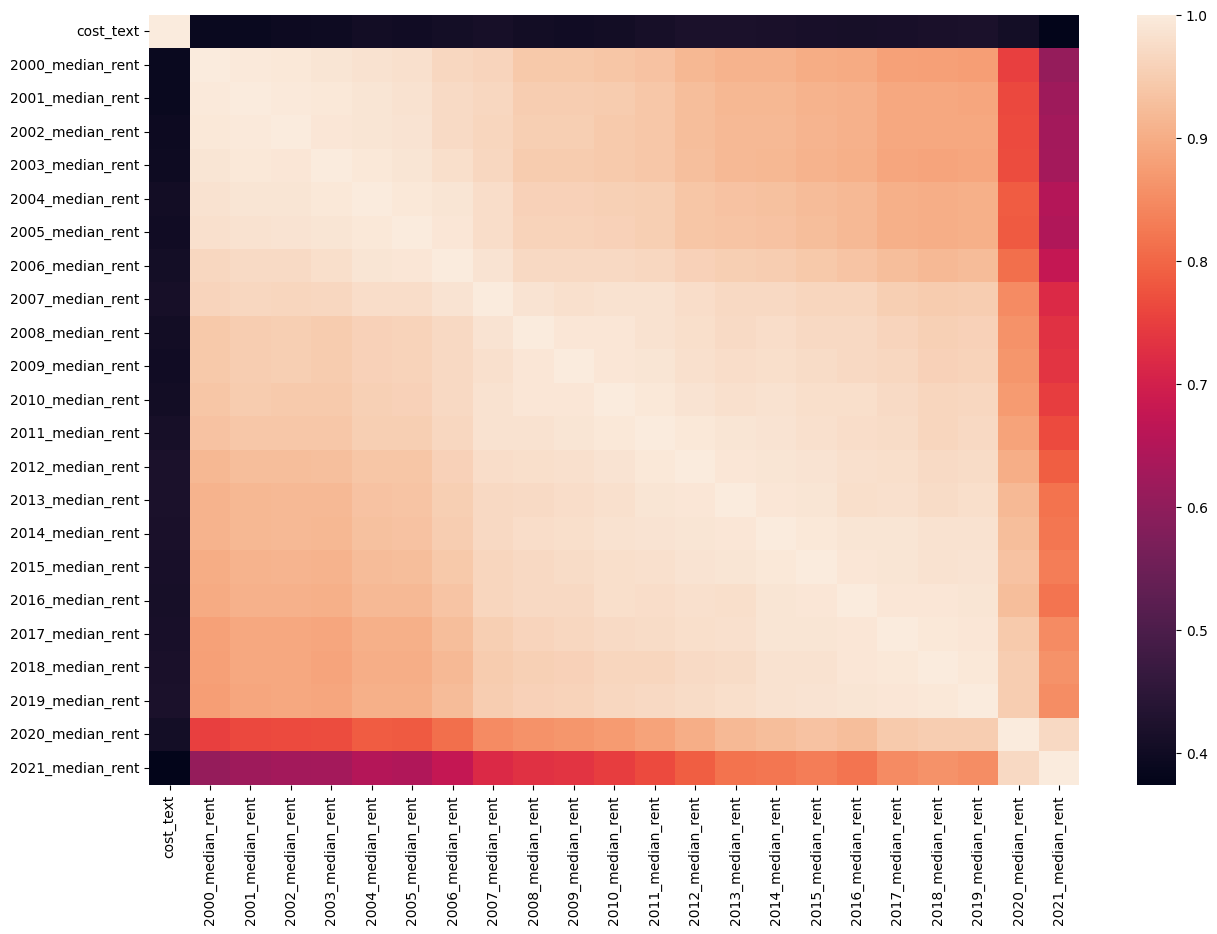

In [36]:
plt.figure(figsize=(15,10))
sns.heatmap(standardize_continuous_cols_external_feats(
    extract_cost_text_and_historical_var_in_external_train(train_data_external_feats, 'median_rent')
)[0].corr())

## <font color='red'>A bit of autocorrelation evident here: the median rents are more correlated to each other as they get closer in time, but not so much (slightly) when they are far apart in time</font>

In [37]:
extract_cost_text_and_historical_var_in_external_train(train_data_external_feats, 'income')

cost_text  2011_annual_income  2012_annual_income  2013_annual_income  \
3929      580.0             63043.0             65938.0             63884.0   
3923      600.0             63043.0             65938.0             63884.0   
3934      575.0             63043.0             65938.0             63884.0   
3916      420.0             63043.0             65938.0             63884.0   
3932      460.0             63043.0             65938.0             63884.0   
...         ...                 ...                 ...                 ...   
1906      265.0             63528.0             66799.0             68348.0   
1858      625.0             63528.0             66799.0             68348.0   
1897      540.0             63528.0             66799.0             68348.0   
1878      445.0             63528.0             66799.0             68348.0   
1866      370.0             63528.0             66799.0             68348.0   

      2014_annual_income  2015_annual_income  2016_annual_income  \
3929             65878.0             69588.0             72002.0   
3923             65878.0             69588.0             72002.0   
3934             65878.0             69588.0             72002.0   
3916             65878.0             69588.0             72002.0   
3932             65878.0             69588.0             72002.0   
...                  ...                 ...                 ...   
1906             70906.0             73604.0             76250.0   
1858             70906.0             73604.0             76250.0   
1897             70906.0             73604.0             76250.0   
1878             70906.0             73604.0             76250.0   
1866             70906.0             73604.0             76250.0   

      2017_annual_income  2018_annual_income  2019_annual_income  \
3929             75384.0        76733.889902        76557.601720   
3923             75384.0        76733.889902        76557.601720   
3934             75384.0        76733.889902        76557.601720   
3916             75384.0        76733.889902        76557.601720   
3932             75384.0        76733.889902        76557.601720   
...                  ...                 ...                 ...   
1906             79585.0        80930.505453        80844.489089   
1858             79585.0        80930.505453        80844.489089   
1897             79585.0        80930.505453        80844.489089   
1878             79585.0        80930.505453        80844.489089   
1866             79585.0        80930.505453        80844.489089   

      2020_annual_income  2021_annual_income  
3929        76381.718542        76206.239437  
3923        76381.718542        76206.239437  
3934        76381.718542        76206.239437  
3916        76381.718542        76206.239437  
3932        76381.718542        76206.239437  
...                  ...                 ...  
1906        80758.564146        80672.730528  
1858        80758.564146        80672.730528  
1897        80758.564146        80672.730528  
1878        80758.564146        80672.730528  
1866        80758.564146        80672.730528  

[2844 rows x 12 columns]

In [38]:
standardize_continuous_cols_external_feats(
    extract_cost_text_and_historical_var_in_external_train(train_data_external_feats, 'income')
)

(      cost_text  2011_annual_income  2012_annual_income  2013_annual_income  \
 3929      580.0            0.069833             0.11861           -0.093791   
 3923      600.0            0.069833             0.11861           -0.093791   
 3934      575.0            0.069833             0.11861           -0.093791   
 3916      420.0            0.069833             0.11861           -0.093791   
 3932      460.0            0.069833             0.11861           -0.093791   
 ...         ...                 ...                 ...                 ...   
 1906      265.0            0.096518             0.16581            0.133609   
 1858      625.0            0.096518             0.16581            0.133609   
 1897      540.0            0.096518             0.16581            0.133609   
 1878      445.0            0.096518             0.16581            0.133609   
 1866      370.0            0.096518             0.16581            0.133609   
 
       2014_annual_income  2015_annual

<AxesSubplot:>

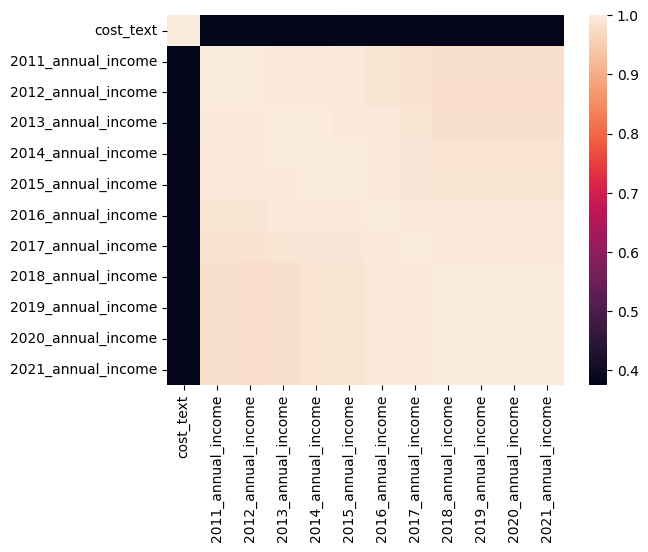

In [39]:
sns.heatmap(standardize_continuous_cols_external_feats(
    extract_cost_text_and_historical_var_in_external_train(train_data_external_feats, 'income')
)[0].corr())

<AxesSubplot:>

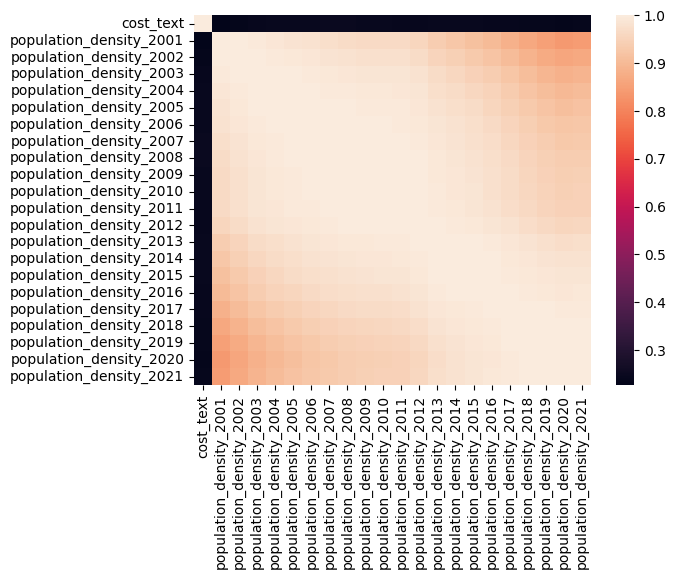

In [40]:
sns.heatmap(standardize_continuous_cols_external_feats(
    extract_cost_text_and_historical_var_in_external_train(train_data_external_feats, 'population_density')
)[0].corr())

<AxesSubplot:>

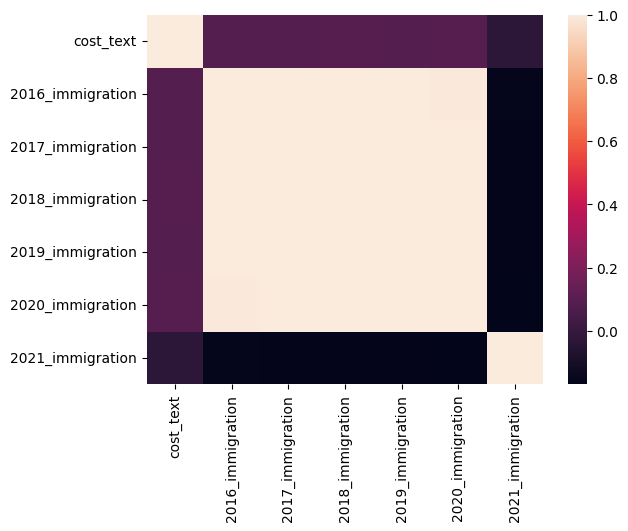

In [41]:
sns.heatmap(standardize_continuous_cols_external_feats(
    extract_cost_text_and_historical_var_in_external_train(train_data_external_feats, 'immigration')
)[0].corr())

<AxesSubplot:>

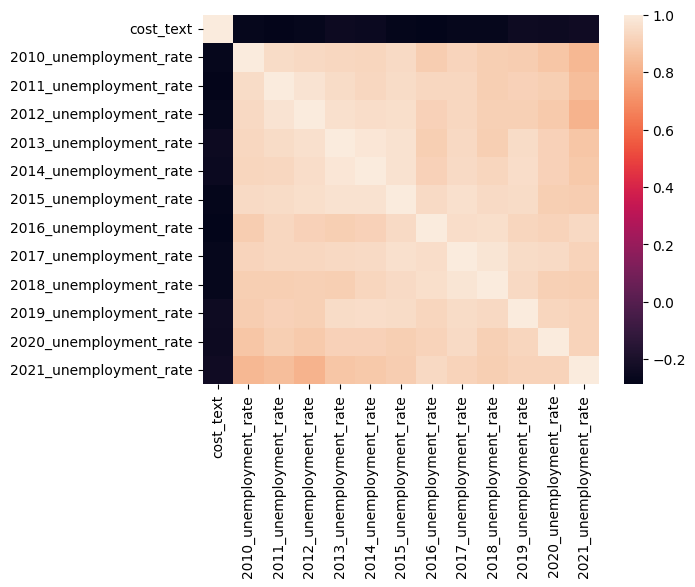

In [42]:
sns.heatmap(standardize_continuous_cols_external_feats(
    extract_cost_text_and_historical_var_in_external_train(train_data_external_feats, 'unemployment')
)[0].corr())

## <font color='red'> This is bad: each of the external features are correlated to each other throughout the years. For now, we'll fit the full model first with *all* variables then do a comparison to the same model but I will do some feature engineering to reduce the colinearity from such external variables that are correlated to each other throughout the years.</font>

# 3. Modelling Attempts (OLS with regularization) <a name='bookmark3' />

<a href=#TOC>Back to ToC</a>

<font color='blue'>Function to one hot encode categorical variables. </font><a name='OH_encoder' />

In [1490]:
def one_hot_encoder(data, encode_ordinal=True):
    vars_to_encode = list(data.dtypes[data.dtypes.isin(['object','O'])].index)
    
    if encode_ordinal == True:
        vars_to_encode += list(data.dtypes[~data.dtypes.isin(['object','O','float64'])].index)
        
    encoded_output = pd.get_dummies(data=data.copy(),
                   columns=vars_to_encode)
    
    encoded_output = encoded_output.astype('float64')
        
    return encoded_output


<font color='blue'>Function to preprocess vars; so far: standardize + OH encode </font><a name='std_and_OH' />

In [44]:
def preprocess_vars_for_train(train_data, encode_ordinal=True):
    
    """
    Preprocessed columns before hyperparameter tuning
    and/or model fitting. So far, we have to: 
    1. Standardize numeric attributes
    2. One hot encode nominal attributes. 
    
    There is a choice to whether encode ordinal attributes
    or not. But normally we wouldn't, so encode_ordinal 
    would stay as True.
    """
    
    
    train_data_out = train_data.copy()
    
    #if, somehow, we have a compelling justification
    #to treat ordinal attributes as continuous/numeric
    if encode_ordinal == False:
        ordinal_cols = train_data_out.dtypes[
            ~train_data_out.dtypes.isin(['O','float64','object'])
        ].index
        
        train_data_out.loc[:,ordinal_cols] =\
            train_data_out.loc[:,ordinal_cols].astype('float64')
    
    #standardize numeric attributes. NOTE that the function has 
    #already excluded the response from being standardized!
    train_data_out = standardize_all_continuous_numeric_vars(train_data_out)[0]
    
    
    #OH encoder (if encode_ordinal = False then we only have 
    #to encode categorical cols)
    train_data_out = one_hot_encoder(train_data_out,
                                    encode_ordinal=encode_ordinal)
    
    return train_data_out
    
    

<font color='blue'>Function to "transform"/preprocess test data </font><a name='transform_test_data' />

In [138]:
def preproc_transform_test_data(test_data, train_data):
    """
    In order to obtain predictions for the test data given fitted model to 
    train data, preprocessing steps for test data should be exactly the same 
    with train data and in a way that prevents data leakage.
    - E.g. standardization in test data should be performed 
      with empirical statistics from the TRAINING data. 
    train_data HAS TO BE RAW. 
    """
    
    test_data_output = test_data.copy()
    #1. standardize numeric attributes based on statistics
    #on the TRAINING data
    
    #note we need training data to obtain
    #statistics needed for standardization.
    
    numeric_cols_in_train = list(train_data.dtypes[
        train_data.dtypes == 'float64'
    ].index)
    
    #make sure to remove the response variable. 
    numeric_cols_in_train = list(set(numeric_cols_in_train) -\
                                 set(['cost_text']))
    
    #obtain relevant statistics for standardization
    stats_for_standard = train_data.loc[:,numeric_cols_in_train].\
                                            agg(['mean','std'])
    
    #numeric cols in test should be the same to numeric cols in train.
    
    #standardize test data based on statistics from TRAINING data
    
    test_data_output.loc[:,numeric_cols_in_train] =\
    (test_data_output.loc[:,numeric_cols_in_train] - stats_for_standard.loc['mean',numeric_cols_in_train]) /\
                     stats_for_standard.loc['std',numeric_cols_in_train]
    
    #2. one-hot encode categorical and ordinal variables in the test data
    test_data_output = one_hot_encoder(test_data_output, 
                                       encode_ordinal=True)
    
    
    #NOTE: 1. some nominal values in the test data may NOT in
    #the training data, or
    #2. some nominal values in training data may NOT be in 
    #the test data. Soln: preprocess training data to see the actual columns
    #of the training data first (incl. after OH encoding)
    train_data_preproc = preprocess_vars_for_train(train_data, encode_ordinal=True)
    
    #by resetting columns in test data with training data, columns that are in 
    #the test data but not in training data will disappear.
    #if col in training data not in testing data then it will appear as NaNs
    #in the testing data. Solution is to just fill them with 0s, it won't
    #artificially affect the predictions. 
    test_data_output = pd.DataFrame(test_data_output, columns=train_data_preproc.columns).fillna(0)
    
    return test_data_output
    

# 3.1 Full model without any feature engineering, just standardizing continuous numerical vars <a name='bookmark3.1' />

<a href=#TOC>Back to ToC</a>

## 3.1.1 CV for choosing hyperparameters for regularization <a name='bookmark3.1.1' />

<a href=#TOC>Back to ToC</a>

<font color='blue'>Function to make formula object to be passed to statsmodels' OLS model</font> <a name='ols_formula_object' />

In [1440]:
def make_formula_object(data, variables='all', response='cost_text'):
    
    """
    Makes a formula object consists of
    the concatenated variable names in strings
    with a '+' separator in between them, like
    lm formula object in R.
    
    Unless variables = 'all' (fit model using ALL variables)
    they MUST be passed as a list of strings. 
    
    """
    
    if variables == 'all':
        variables = data.columns
    
    lm_formula_str = f'{response} ~ '
    
    for variable in variables:
        
        if variable != response:
            
            if data.dtypes[variable] == 'float64':
                
                #if variable starts with a number or whitespace, 
                #statsmodels will throw a vague error.
                #e.g. some of our variables include 
                #e.g. "2006_median_rent"
                
                if (variable[0].isalpha() == False) or (' ' in variable):
                    lm_formula_str += f'Q("{variable}") + '
                    
                else:
                    lm_formula_str += f'{variable} + '
                
            #else we need to model the categorical/ordinal 
            #variable as a treatment contrast by enclosing
            #its name with C()
            
            else:
            
                lm_formula_str += f'C({variable}) + '
    
    
    return lm_formula_str.strip(' + ')

<font color='blue'> Function for K-fold CV</font> <a name='K-fold-CV' />

<a href=#TOC>Back to ToC</a>

In [1676]:
def k_fold_CV(data, k, model, shuffle_data=False, swap_train_test=False, score='MAE', 
              display_entropy_suburbs=False, retransform_log_y=False,
              lambda_best=None):
    
    """
    
    1. Performs a K-fold cross validation
    model evaluation technique on 'data'
    using the tuned model with the training data.
    
    In particular, 
    
    - model should be a ElasticNet() object with 
    alpha specified and n_splits = 0 (reasoning 
    for n_splits = 0: see below) 
    
    - lambda_best should be the lambda that was obtained
    from cross validating the training data 
        - Note that glmnet.ElasticNet(n_splits=n).fit() automatically 
            recomputes best lambda using CV when n > 0. 
            - But in this case we already 
            have a tuned model and we JUST want to EVALUATE it! 
            - So, to prevent another recomputation of lambda, set n_splits=0
    
    
    2. Returns the scores (R2 or MAE)
    In particular, return value is:
    (testing_scores, training_scores)
    
    Each is a list. 
    
    """
    
    N = data.shape[0]
    N_per_fold = N // k
    
    scores_per_test_fold = []
    training_scores_per_iteration = []
    
    entropies_in_training = []
    entropies_in_testing = []
    
    if shuffle_data == True:
        #add code for random permutation if needed.
        #but for now we dont really need it. 
        pass
    
    for fold in range(0,k):
        #obtain testing and training folds
        testing_fold = data.iloc[ (N//k) * fold: (N//k) * (fold+1) ]
        training_folds = data[~data.index.isin(testing_fold.index)]
        
        #preprocess training and testing folds
        #do we want to do the usual CV?
        
        if swap_train_test == False: #usual K-fold CV (one fold = testing)
            
            if display_entropy_suburbs == True:
                
                suburb_entropy_in_training = entropy(training_folds['suburb'].value_counts(normalize=True))
            
                suburb_entropy_in_testing = entropy(testing_fold['suburb'].value_counts(normalize=True))
                
                entropies_in_training.append(suburb_entropy_in_training)
                entropies_in_testing.append(suburb_entropy_in_testing)
            
            
            training_folds_preproc = preprocess_vars_for_train(training_folds, encode_ordinal=True)
            testing_folds_preproc = preproc_transform_test_data(testing_fold, training_folds)
            
            
        else:
            
            if display_entropy_suburbs == True:
                    
                suburb_entropy_in_training = entropy(testing_fold['suburb'].value_counts(normalize=True))
            
                suburb_entropy_in_testing = entropy(training_folds['suburb'].value_counts(normalize=True))
                
                entropies_in_training.append(suburb_entropy_in_training)
                entropies_in_testing.append(suburb_entropy_in_testing)
                
            
            testing_folds_preproc = preprocess_vars_for_train(training_folds, encode_ordinal=True)
            training_folds_preproc = preproc_transform_test_data(testing_fold, training_folds)
        
        
        #train the model on training folds
        model_fitted = model.fit(
                #have to pass 2d array. and make sure to exclude response!
                training_folds_preproc.drop(columns='cost_text').values,
                training_folds_preproc['cost_text']
        )
        
        
        if score == 'R2':
        
            #get testing score
            score_per_test_fold = model_fitted.score(
                testing_folds_preproc.drop(columns='cost_text').values,
                testing_folds_preproc['cost_text'],
                lamb=lambda_best
            )

            #get training score
            training_score_per_iteration = model_fitted.score(
                training_folds_preproc.drop(columns='cost_text').values,
                training_folds_preproc['cost_text'],
                lamb=lambda_best
            )
            
        if score == 'MAE':
            
            #note: since MAE represents the DEVIATIONS between predicted
            #and actual value one way to inverse it is to multiply by -1
            
            #1. get testing prediction, and evaluate mean absolute error
            predict_test = model_fitted.predict(
                testing_folds_preproc.drop(columns='cost_text').values,
                lamb=lambda_best
            )
            
            #we might do a log transform on response as part
            #of feature engineering. Take its inverse back.
            if retransform_log_y == True:
                score_per_test_fold = np.exp(testing_folds_preproc['cost_text']) -\
                                        np.exp(predict_test)
                score_per_test_fold = -1 * np.mean(abs(score_per_test_fold))
                
                
            else:
                score_per_test_fold = testing_folds_preproc['cost_text'] - predict_test
                score_per_test_fold = -1 * np.mean(abs(score_per_test_fold))
            
            
            
            #2. get training prediction/fitted values, and evaluate mean absolute error
            predict_train = model_fitted.predict(
                training_folds_preproc.drop(columns='cost_text').values,
                lamb=lambda_best
            )
            
            #we might do a log transform on response as part
            #of feature engineering. Take its inverse back.
            
            if retransform_log_y == True:
                training_score_per_iteration = np.exp(training_folds_preproc['cost_text']) -\
                                                np.exp(predict_train)
                training_score_per_iteration = -1 * np.mean(abs(training_score_per_iteration))
                
            else:
                training_score_per_iteration = training_folds_preproc['cost_text'] - predict_train
                training_score_per_iteration = -1 * np.mean(abs(training_score_per_iteration))

        scores_per_test_fold.append(score_per_test_fold)
        training_scores_per_iteration.append(training_score_per_iteration)
        
    scores_per_test_fold = np.array(scores_per_test_fold)
    training_scores_per_iteration = np.array(training_scores_per_iteration)
    
    print("Scores for test folds: ", scores_per_test_fold)
    if display_entropy_suburbs == True:
        print("Suburb entropies for test folds: ", entropies_in_testing)
    
    print('\n')
    
    print("Scores for training folds: ", training_scores_per_iteration)
    if display_entropy_suburbs == True:
        print("Suburb entropies for training folds: ", entropies_in_training)
    
    return scores_per_test_fold, training_scores_per_iteration


<font color='blue'>Function: hyperparameter tuning for penalized regression (elastic net): which penalty method (i.e. alpha) produces the somewhat optimal model? </font> <a name='elasticNetHyp' />

<a href=#TOC>Back to ToC</a>

In [1663]:
def best_penalty_method_elastic_net(preproc_train_data,
                                      n_splits=10,
                                      scoring='mean_absolute_error',
                                      random_state=1):
    
    alphas_to_iterate = np.linspace(0,1,20)
    best_lambdas_per_alpha = []
    best_scores_per_alpha = []
    
    #for a specified scoring method, test the penalty method: 
    #more leaning towards LASSO or ridge regression? 
    for alpha in np.linspace(0,1,20):
        
        #specify the model 
        elastic_net_model = ElasticNet(
                               alpha=alpha, 
                               n_splits=n_splits, 
                               scoring=scoring,
                               random_state=random_state
                              ) 
        
        #fit the model with our data
        elastic_net_model_fit = elastic_net_model.fit(
            #have to pass 2d array. and make sure to exclude response!
            preproc_train_data.drop(columns='cost_text').values,
            preproc_train_data['cost_text']
        )
        
        #best penalty weight 
        best_lambdas_per_alpha.append(elastic_net_model_fit.lambda_best_[0])
        
        #the best score according to the best penalty weight
        best_scores_per_alpha.append(
            elastic_net_model_fit.cv_mean_score_[-1]
        )
    
    best_alpha = alphas_to_iterate[np.argmax(best_scores_per_alpha)]
    
    #distinguish between the model as is and the FITTED model with the 
    #training data. 
    
    potentially_best_model_fit = ElasticNet(
                               alpha=best_alpha, 
                               n_splits=0, 
                               scoring=scoring,
                               random_state=random_state
                              )
    
    potentially_best_model_fitted = ElasticNet(
                               alpha=best_alpha, 
                               n_splits=n_splits, 
                               scoring=scoring,
                               random_state=random_state
                              ).fit(
            #have to pass 2d array. and make sure to exclude response!
            preproc_train_data.drop(columns='cost_text').values,
            preproc_train_data['cost_text']
        )
    
        
    return {'alpha': alphas_to_iterate,
            'best_lambdas_per_alpha': best_lambdas_per_alpha,
            'best_scores_per_alpha': best_scores_per_alpha,
            'best_alpha': best_alpha,
            'potentially_best_model': potentially_best_model_fit,
            'potentially_best_model_fitted': potentially_best_model_fitted
            
            }
        
    
    

Each function call: for a specific value of $\alpha$, use 10-fold cross validation to find out optimal value of $\lambda$.
- Optimal here depends on which scoring metric one wants to use

In [880]:
train_data_strat_preproc = preprocess_vars_for_train(train_data_strat, encode_ordinal=True)

In [1678]:
best_model_choice_in_train_with_MAE = best_penalty_method_elastic_net(train_data_strat_preproc,
                                      n_splits=10,
                                      scoring='mean_absolute_error',
                                      random_state=1)

# best_model_choice_in_train_with_R2 = best_penalty_method_elastic_net(train_data_strat_preproc,
#                                       n_splits=9,
#                                       scoring='r2',
#                                       random_state=1)

# best_model_choice_in_train_with_MeAE = best_penalty_method_elastic_net(train_data_strat_preproc,
#                                       n_splits=9,
#                                       scoring='median_absolute_error',
#                                       random_state=1)


In [1683]:
#score training data (R2)
best_model_choice_in_train_with_MAE['potentially_best_model_fitted'].score(
    train_data_strat_preproc.drop(columns='cost_text').values,
    train_data_strat_preproc['cost_text']
)

array(0.6266347)

In [1687]:
#score testing data (R2)
test_data_strat_preproc = preproc_transform_test_data(test_data_strat, train_data_strat)

best_model_choice_in_train_with_MAE['potentially_best_model_fitted'].score(
    test_data_strat_preproc.drop(columns='cost_text').values,
    test_data_strat_preproc['cost_text']
)

array(0.6019497)

Another way to obtain predictions for training and testing data WITHOUT passing the fitted training model is shown in the cells below. 
- This is extremely important because when we want to evaluate using either K-fold CV or learning curve we have to make sure that we are evaluating the SAME model (that is, the model with the *SPECIFIC* HYPERPARAMETERS we've obtained in the *training* data) throughout the iterations
    - That's because ElasticNet(n_splits=n).fit(X_train, y_train) **AUTOMATICALLY** recomputes best lambda for the model fitted with X_train and y_train **if n > 1**.

In [1688]:
#obtain best lambda from CV in training data
lambda_best_model_1 = best_model_choice_in_train_with_MAE['potentially_best_model_fitted'].lambda_best_[0]

In [1691]:
#here n_splits = 0. It's not the actual fitted model. We specify the best lambda later in the score() function
best_model_choice_in_train_with_MAE['potentially_best_model']

ElasticNet(alpha=0.0, n_splits=0, random_state=1, scoring='mean_absolute_error')

In [1694]:
X_train = train_data_strat_preproc.drop(columns='cost_text').values
y_train = train_data_strat_preproc['cost_text']
X_test = test_data_strat_preproc.drop(columns='cost_text').values
y_test = test_data_strat_preproc['cost_text']

print(best_model_choice_in_train_with_MAE['potentially_best_model'].\
        fit(X_train,
            y_train).\
        score(X_test,
              y_test,
              lamb=lambda_best_model_1),
      
      best_model_choice_in_train_with_MAE['potentially_best_model'].\
        fit(X_train,
            y_train).\
        score(X_train,
              y_train,
              lamb=lambda_best_model_1)
     )

0.601949696686438 0.6266347031928858


As expected the R2 are the same as the above.

In [1695]:
pd.DataFrame(
    
    index=['Intercept'] + list(train_data_strat_preproc.drop(columns='cost_text').columns), 
    
    data=[best_model_choice_in_train_with_MAE['potentially_best_model_fitted'].intercept_] +\
                list(best_model_choice_in_train_with_MAE['potentially_best_model_fitted'].coef_), 
    
    columns=['Coefficient (MAE)']
)

Coefficient (MAE)
Intercept                     550.118845
nearest_hospital                0.654370
nearest_train_station           0.998467
distance_to_cbd                 1.950499
nearest_school                  0.156040
...                                  ...
parking_spaces_2               25.556933
parking_spaces_3               32.054212
parking_spaces_4               35.980444
parking_spaces_5              -11.727916
parking_spaces_6                7.636216

[269 rows x 1 columns]

In [62]:
# pd.DataFrame(
    
#     index=['Intercept'] + list(train_data_strat_preproc.drop(columns='cost_text').columns), 
    
#     data=[best_model_choice_in_train_with_R2['potentially_best_model'].intercept_] +\
#                 list(best_model_choice_in_train_with_R2['potentially_best_model'].coef_), 
#     columns=['Coefficient (R2)']
# )

In [63]:
# pd.DataFrame(
    
#     index=['Intercept'] + list(train_data_strat_preproc.drop(columns='cost_text').columns), 
    
#     data=[best_model_choice_in_train_with_MeAE['potentially_best_model'].intercept_] +\
#                 list(best_model_choice_in_train_with_MeAE['potentially_best_model'].coef_), 
#     columns=['Coefficient (MeAE)']
# )

So many of the coefficients are supposedly 0 regardless of the scoring metric we use

<font color='blue'>Function for residual plot.  </font> <a name='residualPlotFunc' />

<a href=#TOC>Back to ToC</a>

In [1049]:
def residual_plot(model_fitted, X, y):
    
    """
    Residual plot of a regression model
    'model'. 
    
    model_fitted, as the name suggests, should 
    be a model object THAT HAS BEEN FITTED to 
    X using .fit().
    
    X is the preprocessed test/train data,
    response MUST BE excluded. X has to be a 
    2-D array representation of a DF. 
    
    y is the response corresponding to data
    in X. 
    
    """
    
    fitted_vals = model_fitted.predict(X)
    
    residuals = fitted_vals - y
    
    plt.figure(figsize=(14,6))
    
    plt.subplot(1,2,1)
    plt.scatter(fitted_vals, residuals)
    plt.title('Regression Fitted Values VS Residuals')
    plt.xlabel('Fitted values')
    plt.ylabel('Residuals')
    
    plt.subplot(1,2,2)
    plt.title('Distribution of overall residuals')
    residuals.hist(bins=200)
    display(round(residuals,3).describe())
    
    return {'fitted_vals': fitted_vals,
            'residuals':residuals}
    

In [935]:
len(best_model_choice_in_train_with_MAE['potentially_best_model_fitted'].coef_)

268

count    2844.000000
mean        0.000002
std       125.386311
min      -800.901000
25%       -41.531750
50%        20.890000
75%        70.336250
max       486.126000
Name: cost_text, dtype: float64

{'fitted_vals': array([519.38882463, 575.9864864 , 519.51702583, ..., 510.35470045,
        448.8432872 , 595.70101564]),
 'residuals': 3898    -80.611175
 3897     25.986486
 3918     39.517026
 3933    -58.290922
 3912     60.239480
            ...    
 1886    116.938566
 1865    -89.710633
 1874    -89.645300
 1899    -71.156713
 1882    -99.298984
 Name: cost_text, Length: 2844, dtype: float64}

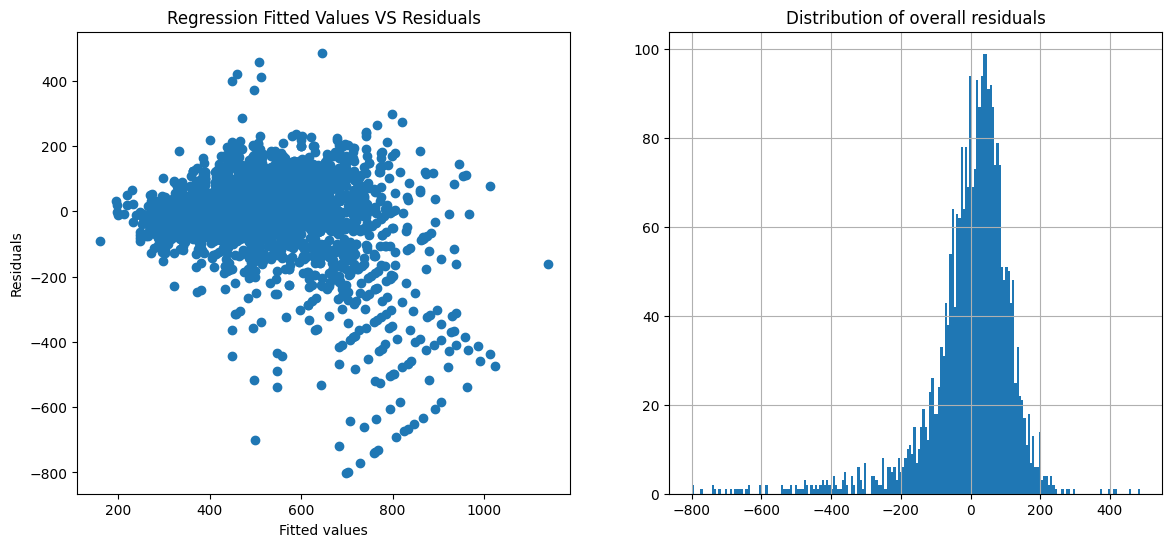

In [1696]:
residual_plot(best_model_choice_in_train_with_MAE['potentially_best_model_fitted'], 
              train_data_strat_preproc.drop(columns='cost_text').values, 
              train_data_strat_preproc['cost_text'])

## 3.1.2 Peform K-fold cross validation on full data with full model in 3.1 <a name='bookmark3.1.2' />

<a href=#TOC>Back to ToC</a>

## Try to perform K-fold on full model (regularized) on the full data.

In [1699]:
full_model = best_model_choice_in_train_with_MAE['potentially_best_model']
k_fold_scores_full_model_full_data = k_fold_CV(final_data, 
          10, 
          full_model, 
          shuffle_data=False,
          swap_train_test=False,
          lambda_best=lambda_best_model_1)

display(k_fold_scores_full_model_full_data)
display(np.mean(k_fold_scores_full_model_full_data[0]), 
       np.mean(k_fold_scores_full_model_full_data[1]))

Scores for test folds:  [ -78.34691941  -76.97671392  -77.51508219 -102.81930301 -115.23397373
 -100.41557068  -82.97643591  -91.54612428  -86.95489828  -84.38119232]


Scores for training folds:  [-85.27341835 -84.88885409 -85.54920218 -82.97684269 -82.17906133
 -83.66639068 -84.55875436 -83.34014704 -84.22078632 -84.20371133]


(array([ -78.34691941,  -76.97671392,  -77.51508219, -102.81930301,
        -115.23397373, -100.41557068,  -82.97643591,  -91.54612428,
         -86.95489828,  -84.38119232]),
 array([-85.27341835, -84.88885409, -85.54920218, -82.97684269,
        -82.17906133, -83.66639068, -84.55875436, -83.34014704,
        -84.22078632, -84.20371133]))

-89.71662137384756

-84.08571683779586

## 3.1.3 Learning curve for our full model (fitted with MAE) <a name='bookmark3.1.3' />

<a href=#TOC>Back to ToC</a>

In [1648]:
def plot_learning_curve(model, data, max_k=3, output=True, scoring='MAE', 
                        display_entropy_suburbs=False, retransform_log_y=False,
                        lambda_best=None):
    
    train_scores = []
    test_scores = []
    train_sizes = []
    
    N = data.shape[0]
    
    k_values = list(range(2, max_k+1))
    
    for k in k_values[::-1]: #k_values: max_k, decrease to 2
        
        k_fold_scores =\
            k_fold_CV(data,
            k, 
            model, 
            shuffle_data=False,
            swap_train_test=True,
            score=scoring,
            display_entropy_suburbs=display_entropy_suburbs,
            retransform_log_y=retransform_log_y,
            lambda_best=lambda_best)
        
        train_scores.append( k_fold_scores[1] )
        test_scores.append( k_fold_scores[0] )
        
        train_sizes.append( 
            int( N * (1/k) )
        )
        
        print(f'train_size for above: {int( N * (1/k) )}({round(100*1/k,2)}%)')
        print('\n')
        
    for k in k_values[1:]: #k_values: 3, increase to max_k
        
        #the number of folds k in k-fold will
        #depend on the train sizes used for the
        #training folds
        
        k_fold_scores =\
            k_fold_CV(data,
            k, 
            model, 
            shuffle_data=False,
            swap_train_test=False,
            score=scoring,
            display_entropy_suburbs=display_entropy_suburbs,
            retransform_log_y=retransform_log_y,
            lambda_best=lambda_best)
        
        train_scores.append( k_fold_scores[1] ) 
        test_scores.append( k_fold_scores[0]) 
        
        train_sizes.append( 
            int( N * ((k-1)/k) )
        )
        
        print(f'train_size for above: {int( N * ((k-1)/k) )}({round(100*((k-1)/k),2)}%)')
        print('\n')
    
    test_scores = np.array(test_scores)
    train_scores = np.array(train_scores)
    
    if output:
        print("train set sizes, training set scores, testing set scores below:\n")
        print(train_sizes, train_scores[0:5], '\n\n', test_scores[0:5])
    
    
    #using np.vectorise preceding
    #np.mean: cant find a way to reshape np arrays so that it won't throw errors
    #otherwise numpys a bit pedantic to not simply able to take means of rows..
    
    
    plt.figure(figsize=(10,10))
    plt.title(f'{scoring} of Training Set and Holdout Set as a Function of Training Set Size')
    plt.plot(train_sizes, np.vectorize(np.mean)(train_scores),label='line with marker',marker='o')
    plt.plot(train_sizes, np.vectorize(np.mean)(test_scores),label='line with marker',marker='o')
    plt.xlabel('Size of Training Data')
    plt.ylabel(f'{scoring}')
    plt.legend([f'training {scoring}', f'holdout {scoring}'])
    
    return [np.vectorize(np.mean)(train_scores), np.vectorize(np.mean)(test_scores)]

Scores for test folds:  [-102.12781033  -98.91502389  -93.78001521  -97.6254739   -95.73934983
  -97.27280444 -101.80722839  -92.31457345  -91.59355141  -91.63350922]


Scores for training folds:  [-72.49090704 -76.6128326  -70.65458798 -92.21674553 -98.04412482
 -88.25440474 -78.01230516 -90.96617857 -83.27766779 -83.95574014]
train_size for above: 569(10.0%)


Scores for test folds:  [-101.64534723 -103.86169352  -89.69897855 -100.94709921  -96.87715875
 -100.87438298  -94.67894913  -93.48987318  -91.25016051]


Scores for training folds:  [-72.73749851 -73.32314189 -82.05671828 -87.83359963 -92.65912713
 -86.99025961 -72.81179109 -90.9116344  -86.09956145]
train_size for above: 632(11.11%)


Scores for test folds:  [ -99.94937017  -99.83366563  -93.7515039  -101.3049876   -96.70084736
  -92.92335846  -93.96898076  -91.13712134]


Scores for training folds:  [-76.71956405 -68.59024393 -93.64617018 -94.33934464 -89.20433506
 -74.06377345 -92.96108299 -85.46273361]
train_size for above

/tmp/ipykernel_870/3184143871.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  test_scores = np.array(test_scores)
/tmp/ipykernel_870/3184143871.py:64: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  train_scores = np.array(train_scores)


[array([-83.44854944, -82.82481467, -84.37340599, -83.96694047,
        -84.60904474, -86.18652137, -86.57291898, -86.91818294,
        -87.63315488, -83.95944567, -84.06699563, -84.0697369 ,
        -84.06840914, -84.0611634 , -84.09208232, -84.038667  ,
        -84.08571684]),
 array([-96.28093401, -97.03596034, -96.19622941, -95.09894397,
        -95.54670522, -91.78339489, -93.59631584, -90.86052922,
        -92.09817613, -90.63069064, -91.02982471, -89.38631192,
        -90.60267922, -89.92972293, -90.12535109, -89.50023887,
        -89.71662137])]

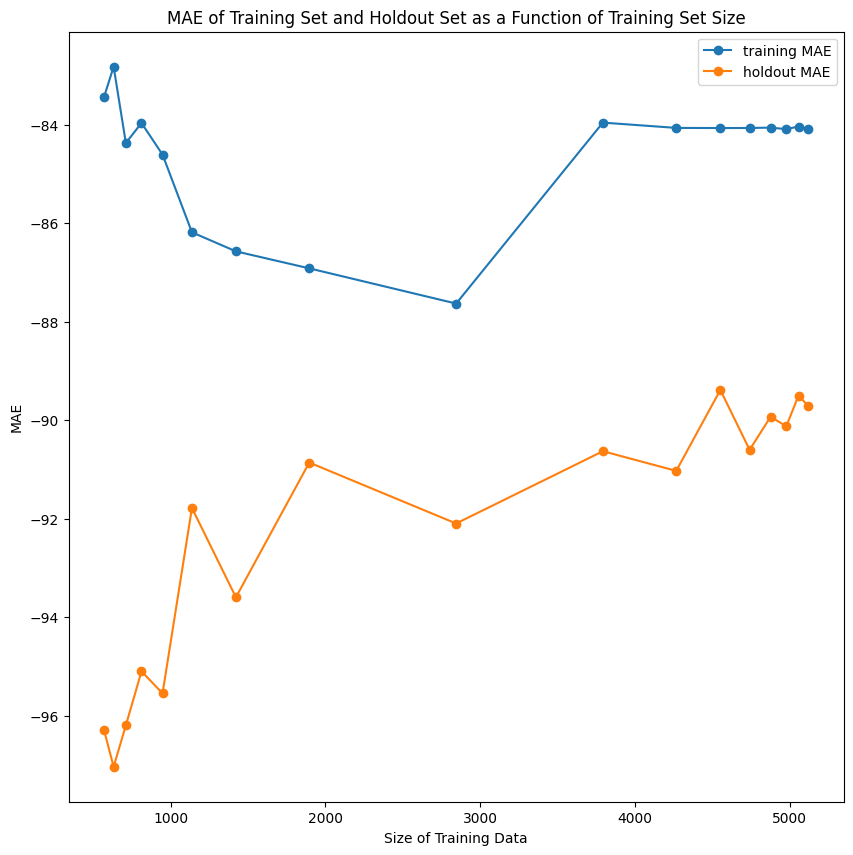

In [1700]:
plot_learning_curve(full_model, 
                    final_data,
                    max_k=10,
                    output=False,
                    scoring='MAE',
                    lambda_best=lambda_best_model_1)

In [326]:
historical_external_cols = extract_col_with_historical_values_from_df(train_data_strat)

# Geospatial: Visualise residuals per suburb

count    2844.000000
mean        0.000002
std       125.386311
min      -800.901000
25%       -41.531750
50%        20.890000
75%        70.336250
max       486.126000
Name: cost_text, dtype: float64

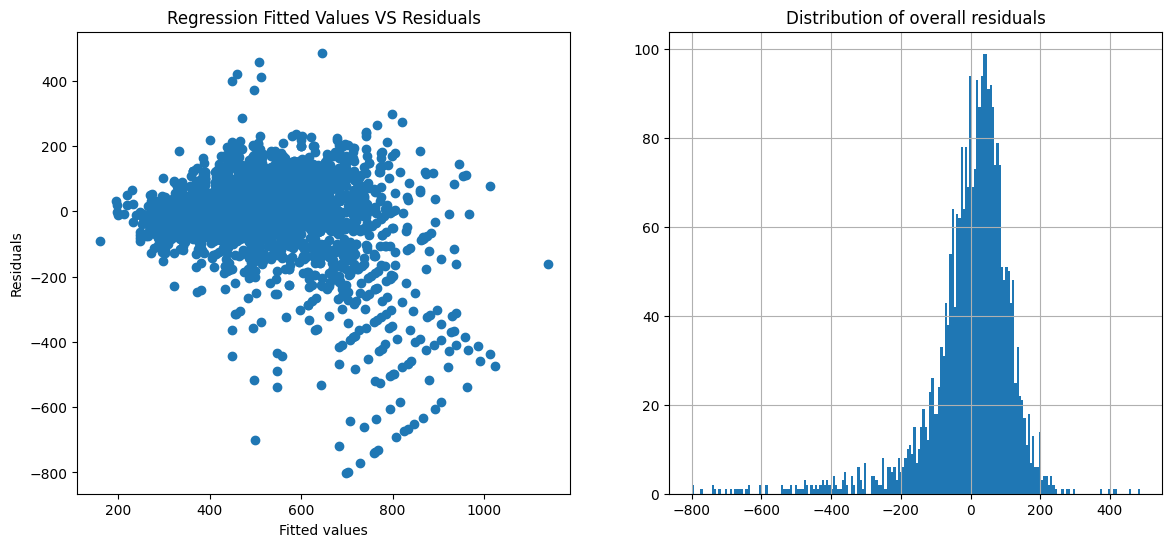

In [1051]:
fitted_vals_and_residuals_first_model = residual_plot(best_model_choice_in_train_with_MAE['potentially_best_model_fitted'], 
              train_data_strat_preproc.drop(columns='cost_text').values, 
              train_data_strat_preproc['cost_text'])

<AxesSubplot:>

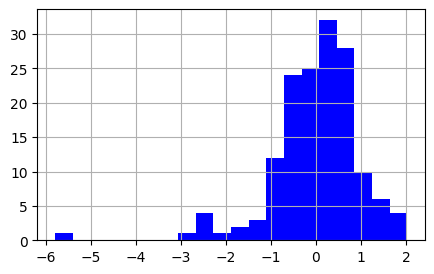

In [1113]:
residuals_and_suburb = pd.DataFrame(final_data['suburb']).merge(
    pd.DataFrame(fitted_vals_and_residuals_first_model['residuals']),left_index=True,right_index=True
).rename(columns={'cost_text':'residuals_first_model'})

#find the mean of residuals per suburb
residuals_and_suburb = residuals_and_suburb.groupby('suburb')['residuals_first_model'].mean().reset_index()

#standardize the residuals
residuals_and_suburb.loc[:,'residuals_first_model'] = stats.zscore(residuals_and_suburb.loc[:,'residuals_first_model'])

#visualise the residuals for a moment
residuals_and_suburb.iloc[:,1].hist(bins=20, color='blue', figsize=(5,3))

In [1114]:
geopandas_plotting(residuals_and_suburb, 
                       sf=vic_shapefile_no_duplicates, 
                       legend_name='Residuals of first model across suburbs', 
                       col_to_be_plot='residuals_first_model',
                       save=False,
                       saved_map_name='',
                       map_format='html')

# 4. Further Feature Engineering<a name='bookmark4' />

<a href=#TOC>Back to ToC</a>

<font color='blue'>Function for any desired feature engineering (**Should be done before preprocessing the columns!**)</font>

In [ ]:
def feature_engineer_column_wise():
    """
    Create another feature (>= 1)
    by combining >= 2 features, NOT by
    aggregating rows.
    
    """

# 4.1 Instead of retaining historical external variables as is, obtain the <code>TIME_LAG</code>-year increase for each of them to reduce multicollinearity<a name='bookmark4.1' />

<a href=#TOC>Back to ToC</a>

## For the external columns, instead of keeping them as is, we could just transform them into annual (or even a custom specified time-lag) increases of each external variable to further reduce multicollinearity
- E.g. <code>2000_median_rent and 2001_median_rent --> df[2001_median_rent] - df[2000_median-rent]</code>

Beware: <code>population_</code> and <code>population_density</code>

In [493]:
def compute_time_lag_increase_historical_external_cols(data, TIME_LAG=1):

    """
    
    PART OF FEATURE ENGINEERING.
    For each external columns that are historical, which
    I define as containing numerical years
    (e.g. 2000_median_rent), to prevent autocorrelation between
    them we compute the TIME_LAG-year increase of them. 
    
    E.g. if TIME_LAG = 1, instead of retaining 2000_median_rent 
    and 2001_median_rent, we compute the TIME_LAG-year increase 
    of median rent from 2000 instead. 
    
    
    """
    
    data_no_external = data.loc[:,~data.columns.str.contains('\d')].copy()
    
    historical_col_annual_increase = pd.DataFrame()

    for i in range(len(historical_external_cols)):
        
        conditions_for_extracting_this_historical_external_col =\
            (data.columns.str.contains('\d')) &\
            (data.columns.str.contains(historical_external_cols[i]))

        if 'population' in historical_external_cols[i]:

            if 'density' not in historical_external_cols[i]:
                is_pop_but_not_pop_density = ~data.columns.str.contains('density')
                conditions_for_extracting_this_historical_external_col =\
                    conditions_for_extracting_this_historical_external_col & is_pop_but_not_pop_density

        one_historical_cols = pd.DataFrame(

            data.loc[:,
                conditions_for_extracting_this_historical_external_col
            ].columns,

            columns=[historical_external_cols[i]]
        )

        #extract the year from a historical external column (e.g. extract '2000' from '2000_median_rent')
        one_historical_cols['years'] = one_historical_cols.iloc[:,0].str.findall('\d+').map(lambda x: x[0]).astype('int64')

        #use year as index: ultimately this will be a dictionary with the years as the keys.. 
        #this will be useful later when we want to obtain the annual increase
        one_historical_cols = one_historical_cols.set_index('years').sort_index().iloc[:,0]


        #START COMPUTING INCREASE

        years_curr_historical_col = one_historical_cols.index

        #display(years_curr_historical_col)


        for j in range(TIME_LAG, len(years_curr_historical_col)):

            year = years_curr_historical_col[j]
            prior_year = years_curr_historical_col[j-TIME_LAG]

            annual_inc_prior_year = data[one_historical_cols[year]] -\
                            data[one_historical_cols[prior_year]]

            annual_inc_col_name = f'{historical_external_cols[i]}_inc_from_{prior_year}_to_{year}'

            #add this annual increase to historical_col_annual_increase
            historical_col_annual_increase[annual_inc_col_name] = annual_inc_prior_year
    
    return pd.concat([data_no_external, historical_col_annual_increase], axis='columns')


# 4.2 Pairwise plot of internal features for any possible transformation <a name='bookmark4.2' />

<a href=#TOC>Back to ToC</a>

In [525]:
train_data_strat.loc[:,~train_data_strat.columns.str.contains('\d')]

cost_text      suburb  bedrooms  bathrooms  parking_spaces  \
3929  -0.469271  abbotsford         2          2               1   
3923  -0.464697  abbotsford         2          1               1   
3934  -0.470448  abbotsford         2          2               1   
3916  -0.515967  abbotsford         1          1               1   
3932  -0.502195  abbotsford         2          1               1   
...         ...         ...       ...        ...             ...   
1906  -0.594525  yarraville         2          1               1   
1858  -0.459265  yarraville         3          1               1   
1897  -0.479107  yarraville         3          1               1   
1878  -0.507155  yarraville         2          1               1   
1866  -0.536040  yarraville         2          1               1   

      nearest_hospital  nearest_train_station  distance_to_cbd  nearest_school  
3929               NaN                 1.1989           4.7871          1.2097  
3923               NaN                 0.0354           3.6661          1.4329  
3934               NaN                 1.2790           4.8672          0.9365  
3916               NaN                 1.2707           4.8588          0.9281  
3932               NaN                 1.9659           4.4827          1.0574  
...                ...                    ...              ...             ...  
1906               NaN                 1.1074           9.5005          1.1435  
1858               NaN                 1.1394          10.9847          0.6450  
1897               NaN                 2.6578          11.5028          1.0160  
1878               NaN                 0.9442           8.6485          1.2341  
1866               NaN                 0.6117           8.9764          0.9191  

[2844 rows x 9 columns]

In [501]:
standardize_all_continuous_numeric_vars(
    train_data_strat.loc[:,~train_data_strat.columns.str.contains('\d')]
)[0].drop(columns='suburb')

cost_text      suburb  bedrooms  bathrooms  parking_spaces  \
3929      580.0  abbotsford         2          2               1   
3923      600.0  abbotsford         2          1               1   
3934      575.0  abbotsford         2          2               1   
3916      420.0  abbotsford         1          1               1   
3932      460.0  abbotsford         2          1               1   
...         ...         ...       ...        ...             ...   
1906      265.0  yarraville         2          1               1   
1858      625.0  yarraville         3          1               1   
1897      540.0  yarraville         3          1               1   
1878      445.0  yarraville         2          1               1   
1866      370.0  yarraville         2          1               1   

      nearest_hospital  nearest_train_station  distance_to_cbd  nearest_school  
3929         -0.243919              -0.340530        -0.527830        0.371941  
3923         -0.373056              -0.481990        -0.547348        0.712044  
3934         -0.234690              -0.330792        -0.526435       -0.044351  
3916         -0.235646              -0.331801        -0.526581       -0.057150  
3932         -0.278977              -0.247277        -0.533130        0.139872  
...                ...                    ...              ...             ...  
1906         -0.253343              -0.351655        -0.445760        0.271068  
1858         -0.335625              -0.347764        -0.419917       -0.488527  
1897         -0.226591              -0.163155        -0.410896        0.076788  
1878         -0.351063              -0.371497        -0.460595        0.409120  
1866         -0.312341              -0.411923        -0.454886       -0.070864  

[2844 rows x 9 columns]

Pairwise plot against internal features, NO transformation applied at all <a name='raw_internal_plot' />

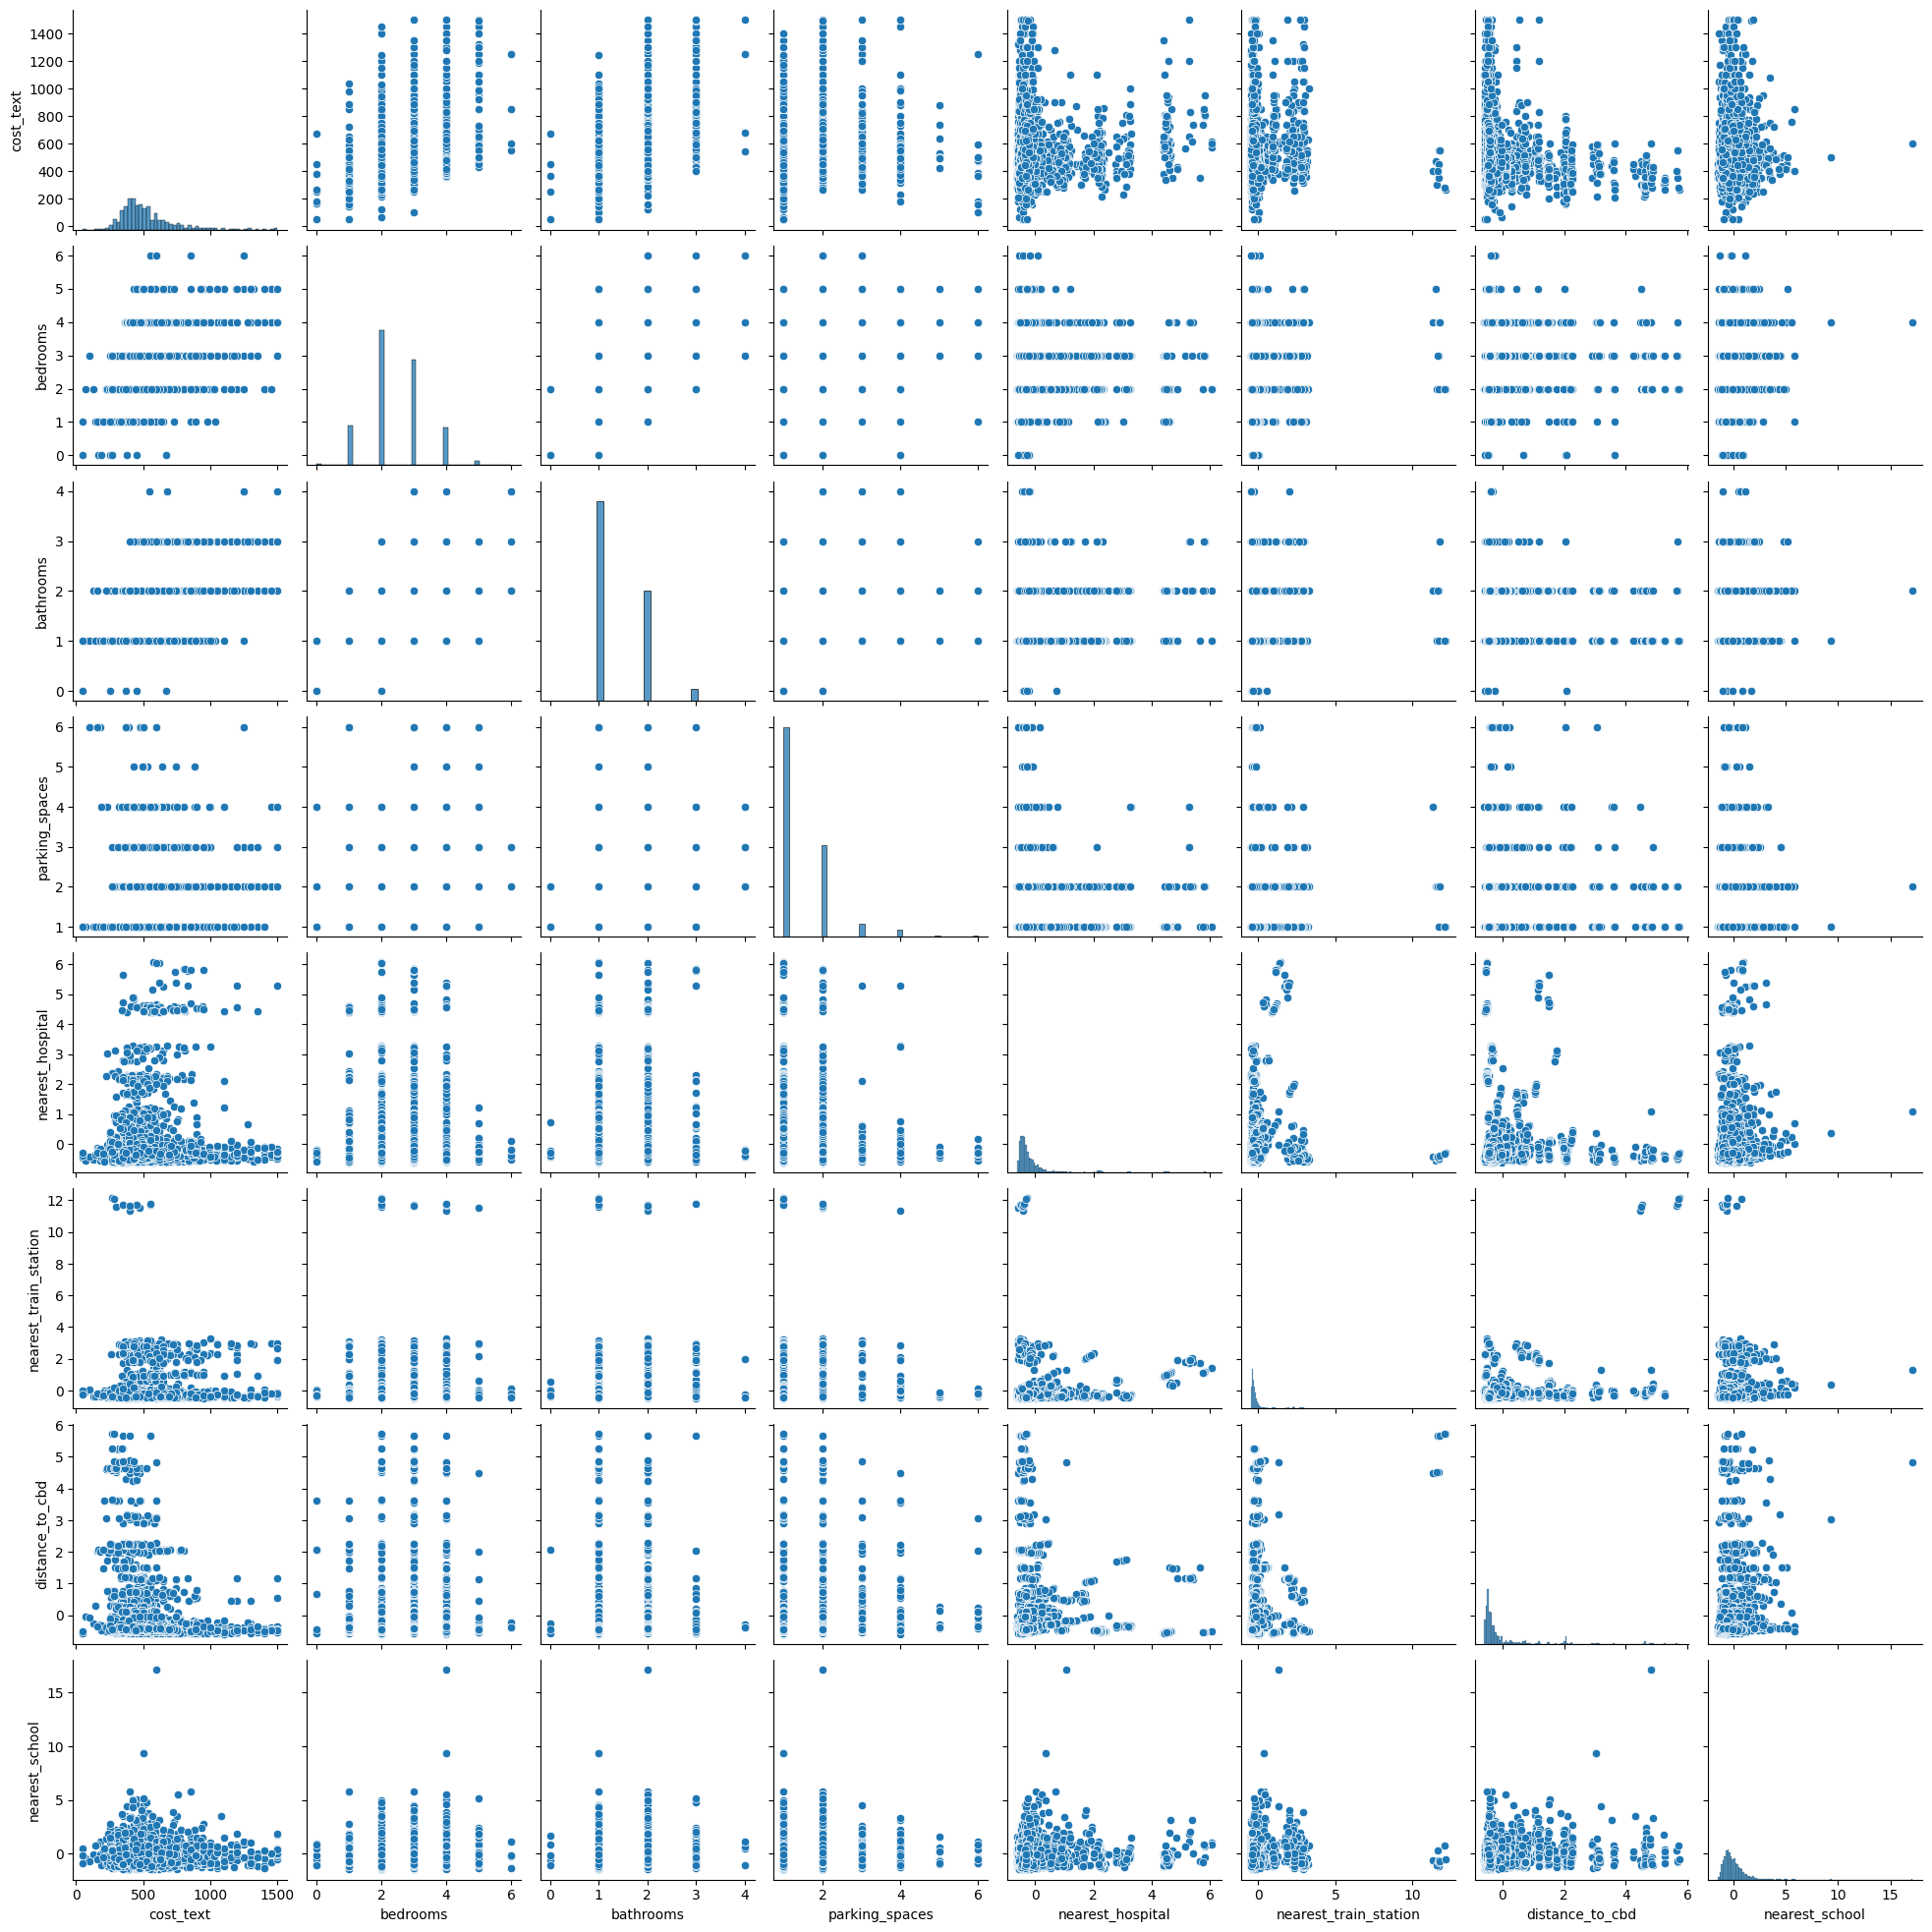

In [502]:
sns.pairplot(
        #standardize them first
        standardize_all_continuous_numeric_vars( #locate all internal + proximity features
            train_data_strat.loc[:,~train_data_strat.columns.str.contains('\d')]
        )[0].drop(columns='suburb')
)

It *seems* that the distances (<code>['nearest_hospital', 'nearest_train_station', 'distance_to_cbd', 'nearest_school']</code>) have some kind of inverse relatinoship with rental price

In [640]:
def variable_transformation(row):
    
    proximity_cols = ['nearest_hospital', 'nearest_train_station', 
                       'distance_to_cbd', 'nearest_school']
    
    #1. Maybe we can log the response.
    
    #distribution of response is skewed, and 
    #probably expect the same trend given the explanatory
    #variables. So try to take log of it. 
    #row['cost_text'] = np.log(row['cost_text'])
    
    
    #2. prevent zero division error, in case a very small
    #proximity value is trunacted to 0 
    
    e = 0.0001 
    proximity_cols = ['nearest_hospital', 'nearest_train_station', 
                      'distance_to_cbd', 'nearest_school']
    
    row[proximity_cols] = 1 / (row[proximity_cols] + e)
    
    
    #3. distribution of proximity variables are skewed. Better take log 
    #as well to not have values more dense in the region closer to 0.
    
#     for col in proximity_cols:
#         row[col] = np.log(row[col])
    
    return row[proximity_cols + ['cost_text']].drop(columns='suburb')
    return row.drop(columns='suburb')

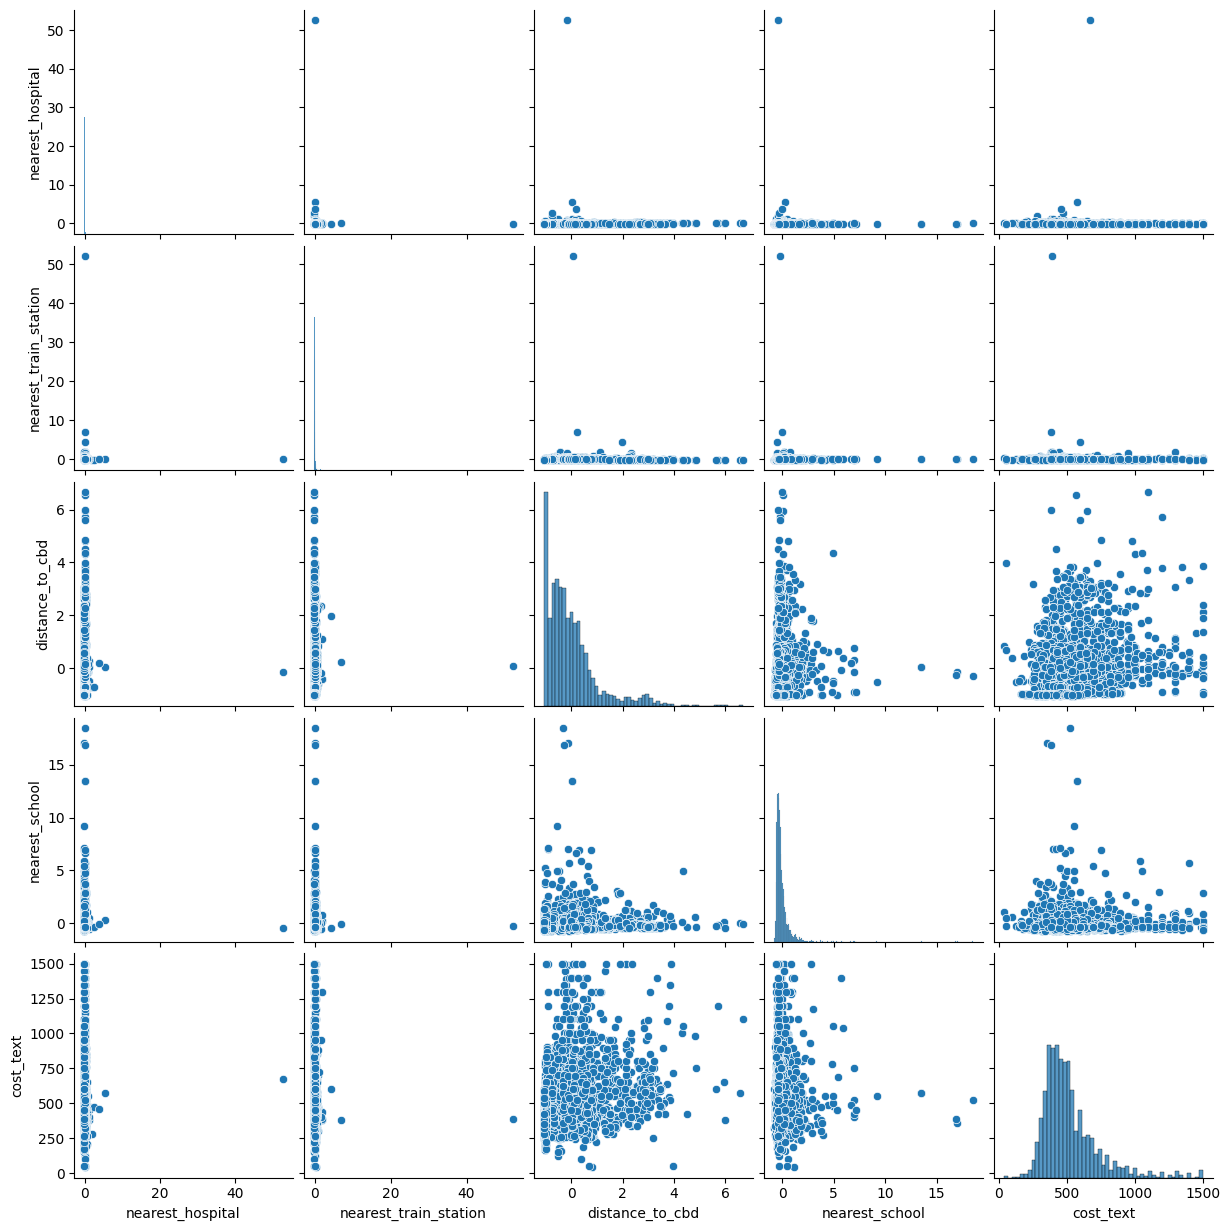

In [641]:
sns.pairplot(
        #standardize them first
        standardize_all_continuous_numeric_vars(
            
            #locate all internal + proximity features
            train_data_strat.loc[:,~train_data_strat.columns.str.contains('\d')].\
                apply(
                    lambda row: variable_transformation(row), axis='columns'
                )
            
        )[0]
)

<a href='#raw_internal_plot'>Based on this plot (distance to cbd vs cost text), it seems that it has the most evident inverse linear relationship</a>

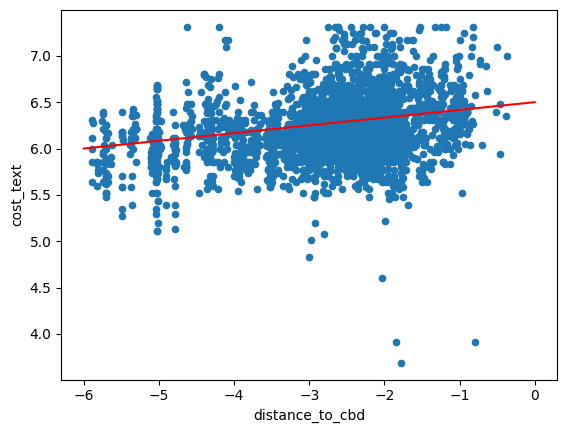

In [1303]:
train_data_strat_copy = train_data_strat.copy()
train_data_strat_copy['distance_to_cbd'] = np.log(1 / (train_data_strat_copy['distance_to_cbd'] + 0.001))
#train_data_strat_copy['distance_to_cbd'] = 1 / (train_data_strat_copy['distance_to_cbd'] + 0.001)
train_data_strat_copy['cost_text'] = np.log(train_data_strat_copy['cost_text'])

train_data_strat_copy.plot.scatter(x='distance_to_cbd',
                                   y='cost_text')
plt.plot([-6, 0], [6, 6.5],color="red")

## <font color='red'> First I take the inverse of distance to cbd, but then the values of distance to cbd are clumped around 0. So I take the log to make it spread out. Also since there are so many instances with proximities (school, hospital, nearest train station) close to 0, I decided to take log of the response as well to avoid heteroscedasicity</font>

# 4.3 Try to do some feature engineerings as specified below: <a name='bookmark4.3' />

- Log cost_text
- log(1/distance to cbd + small_number)
- time lag 1 year increase for historical external features


<a href=#TOC>Back to ToC</a>


In [664]:
def variable_transformation_for_fitting(row):
    
    row['cost_text'] = np.log(row['cost_text'])
    
    e = 0.0001 
    
    row['distance_to_cbd'] = np.log( 1 / (row['distance_to_cbd'] + e) )
    
    
    return row

In [1715]:
def feature_engineering_1(df,
                          with_external_vars=True,
                          TIME_LAG=1):
    
    df_output = df.copy()
    
    if with_external_vars == True:
        df_output = compute_time_lag_increase_historical_external_cols(df_output, 
                                                                       TIME_LAG=TIME_LAG)
    
    df_output = df_output.apply(
        lambda row: variable_transformation_for_fitting(row), axis='columns'
    )
    
    return df_output
    
    

# 4.4 Fitting Model given the feature engineerings [1) time lag for historical external vars 2) transformation for distance to cbd variable 3) log response variable] <a name='bookmark4.4' />

<a href=#TOC>Back to ToC</a>

Try to fit the 2nd model, given feature engineerings

In [1664]:
train_data_strat_preproc_feature_eng_1 = preprocess_vars_for_train(feature_engineering_1(train_data_strat), 
                                                                   encode_ordinal=True)

best_model_choice_in_train_feat_eng_with_MAE = best_penalty_method_elastic_net(train_data_strat_preproc_feature_eng_1,
                                      n_splits=10,
                                      scoring='mean_absolute_error',
                                      random_state=1)


How well does the second model fits our training data?

In [1665]:
best_model_choice_in_train_feat_eng_with_MAE['potentially_best_model_fitted'].score(
    train_data_strat_preproc_feature_eng_1.drop(columns='cost_text').values,
    train_data_strat_preproc_feature_eng_1['cost_text']
)

array(0.69025006)

How well does the second model predicts our test data?

In [1666]:
test_data_strat_preproc_feature_eng_1 =\
    preproc_transform_test_data(feature_engineering_1(test_data_strat), feature_engineering_1(train_data_strat))

In [1667]:
best_model_choice_in_train_feat_eng_with_MAE['potentially_best_model_fitted'].score(
    test_data_strat_preproc_feature_eng_1.drop(columns='cost_text').values,
    test_data_strat_preproc_feature_eng_1['cost_text']
)

array(0.63755159)

Another way to obtain predictions for training and testing data WITHOUT passing the fitted training model. 
- This is extremely important because when we want to evaluate using either K-fold CV or learning curve we have to make sure that we are evaluating the SAME model (that is, the model with the *SPECIFIC* HYPERPARAMETERS we've obtained in the *training* data) throughout the iterations
    - That's because ElasticNet(n_splits=n).fit(X_train, y_train) **AUTOMATICALLY** recomputes best lambda for the model fitted with X_train and y_train **if n > 1**.

In [1658]:
lambda_best_model_2 = best_model_choice_in_train_feat_eng_with_MAE['potentially_best_model_fitted'].lambda_best_[0]
lambda_best_model_2

0.13864249290757513

In [1669]:
ElasticNet(alpha=0, #penalty_weight
           n_splits=0,
           random_state=1,
           ).fit(train_data_strat_preproc_feature_eng_1.drop(columns='cost_text').values,
                train_data_strat_preproc_feature_eng_1['cost_text']).score(X,y,lamb=lambda_best_model_2)

array(0.69025006)

In [1670]:
ElasticNet(alpha=0, #penalty_weight
           n_splits=0,
           random_state=1,
           ).fit(train_data_strat_preproc_feature_eng_1.drop(columns='cost_text').values,
                train_data_strat_preproc_feature_eng_1['cost_text']).\
        score(test_data_strat_preproc_feature_eng_1.drop(columns='cost_text').values,
              test_data_strat_preproc_feature_eng_1['cost_text'],
              lamb=lambda_best_model_2)

array(0.63755159)

In [1674]:
best_model_choice_in_train_feat_eng_with_MAE['potentially_best_model'].\
        fit(train_data_strat_preproc_feature_eng_1.drop(columns='cost_text').values,
                train_data_strat_preproc_feature_eng_1['cost_text']).\
        score(test_data_strat_preproc_feature_eng_1.drop(columns='cost_text').values,
              test_data_strat_preproc_feature_eng_1['cost_text'],
              lamb=lambda_best_model_2)

array(0.63755159)

Do a K-fold cross validation

In [1677]:
k_fold_CV(
    feature_engineering_1(final_data), 
    7, 
    best_model_choice_in_train_feat_eng_with_MAE['potentially_best_model'],
    shuffle_data=False,
    swap_train_test=False,
    retransform_log_y=True,
    lambda_best=lambda_best_model_2
)

Scores for test folds:  [ -78.18537313  -72.43737672  -99.17457565 -101.17908834  -84.30913992
  -95.54025574  -82.8450355 ]


Scores for training folds:  [-76.77641388 -77.98065252 -74.55946935 -74.48193011 -75.77160476
 -75.22569448 -75.62530565]


(array([ -78.18537313,  -72.43737672,  -99.17457565, -101.17908834,
         -84.30913992,  -95.54025574,  -82.8450355 ]),
 array([-76.77641388, -77.98065252, -74.55946935, -74.48193011,
        -75.77160476, -75.22569448, -75.62530565]))

In [1701]:
# #stupid idea: 100 CV to increase actual gap between train and test scores
# hundred_fold_scores_2nd_model_full_data = k_fold_CV(
#     feature_engineering_1(final_data), 
#     100, 
#     best_model_choice_in_train_feat_eng_with_MAE['potentially_best_model'],
#     shuffle_data=False,
#     swap_train_test=False
# )

# display(np.mean(hundred_fold_scores_2nd_model_full_data[0]), 
#        np.mean(hundred_fold_scores_2nd_model_full_data[1]))

Learning Curve 

Scores for test folds:  [-114.72621327 -153.64014357 -105.85641008  -96.94067792  -96.59589053
 -112.80631913 -108.22670417  -93.68667334  -99.84291244 -103.84231647]


Scores for training folds:  [-61.85327087 -67.91234133 -61.99294314 -79.96902987 -89.68658153
 -75.79133041 -67.91420498 -80.9094945  -73.99151172 -75.50473288]
train_size for above: 569(10.0%)


Scores for test folds:  [-115.20909591 -134.1134346   -92.10864401  -90.77683189  -96.45102306
 -118.29354474  -95.05179534  -94.48700405 -104.75545114]


Scores for training folds:  [-62.79213451 -64.82966304 -70.38486353 -78.66565838 -83.31483268
 -75.37568769 -64.23262395 -81.87282744 -77.50701286]
train_size for above: 632(11.11%)


Scores for test folds:  [-112.23182174 -109.39515771  -95.9686154   -89.80002111 -118.85768292
 -114.09330624  -94.62448464  -98.22642109]


Scores for training folds:  [-66.72364279 -61.07040024 -80.10145936 -85.05788135 -76.70727932
 -63.84368165 -82.51680257 -76.93737777]
train_size for above

/tmp/ipykernel_870/3184143871.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  test_scores = np.array(test_scores)
/tmp/ipykernel_870/3184143871.py:64: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  train_scores = np.array(train_scores)


[array([-73.55254412, -73.21947823, -74.11981563, -73.95927638,
        -74.6858232 , -75.20601775, -76.11891276, -76.46602981,
        -78.35700375, -75.54469651, -75.71897773, -75.73520024,
        -75.7723523 , -75.77443868, -75.79838822, -75.74599733,
        -75.81794993]),
 array([-108.61642609, -104.58298053, -104.14968886, -101.13309836,
         -98.50244136,  -99.93657498, -102.60456909,  -90.14746805,
         -88.17969654,  -88.04514024,  -88.84736257,  -87.05278994,
         -87.72873328,  -87.66726357,  -87.8614818 ,  -86.52824648,
         -86.97718088])]

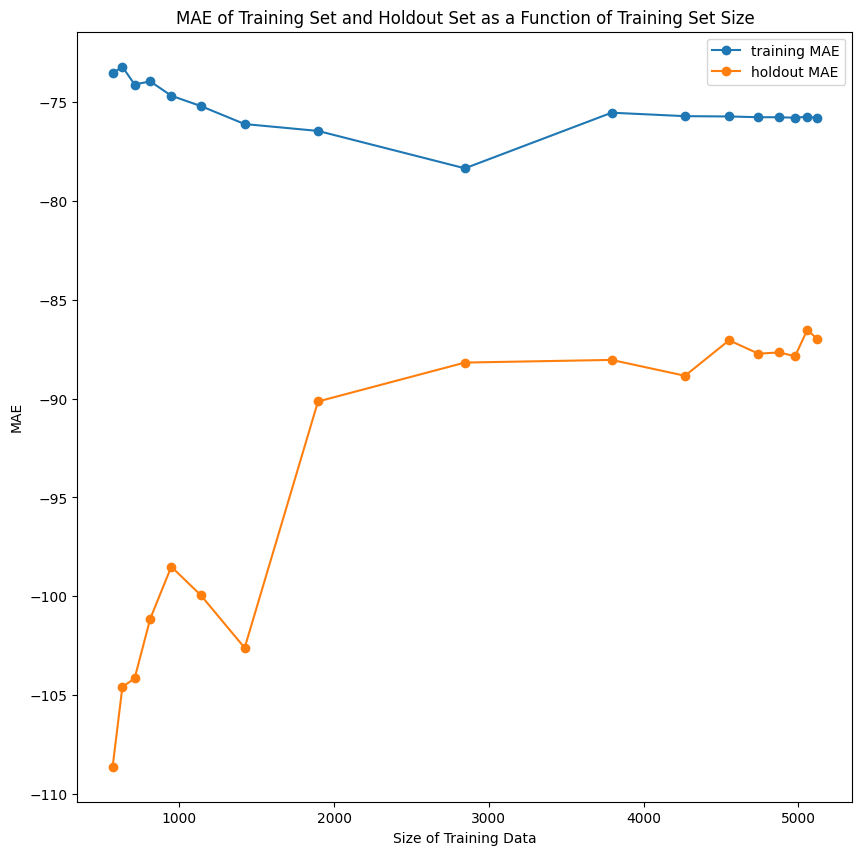

In [1704]:
plot_learning_curve(best_model_choice_in_train_feat_eng_with_MAE['potentially_best_model'], 
                    feature_engineering_1(final_data), 
                    max_k=10, 
                    output=False,
                    retransform_log_y=True,
                    lambda_best=lambda_best_model_2)

In [1706]:
best_model_choice_in_train_feat_eng_with_MAE['potentially_best_model_fitted'].lambda_best_

array([0.13864249])

count    2844.000000
mean        0.000001
std         0.195155
min        -0.893000
25%        -0.097000
50%         0.014000
75%         0.108000
max         2.057000
Name: cost_text, dtype: float64

{'fitted_vals': array([6.24216566, 6.34177675, 6.24257295, ..., 6.22034325, 6.08782084,
        6.39142395]),
 'residuals': 3898   -0.154764
 3897    0.031858
 3918    0.068787
 3933   -0.039197
 3912    0.057706
           ...   
 1886    0.208775
 1865   -0.175920
 1874   -0.176586
 1899   -0.166008
 1882   -0.152488
 Name: cost_text, Length: 2844, dtype: float64}

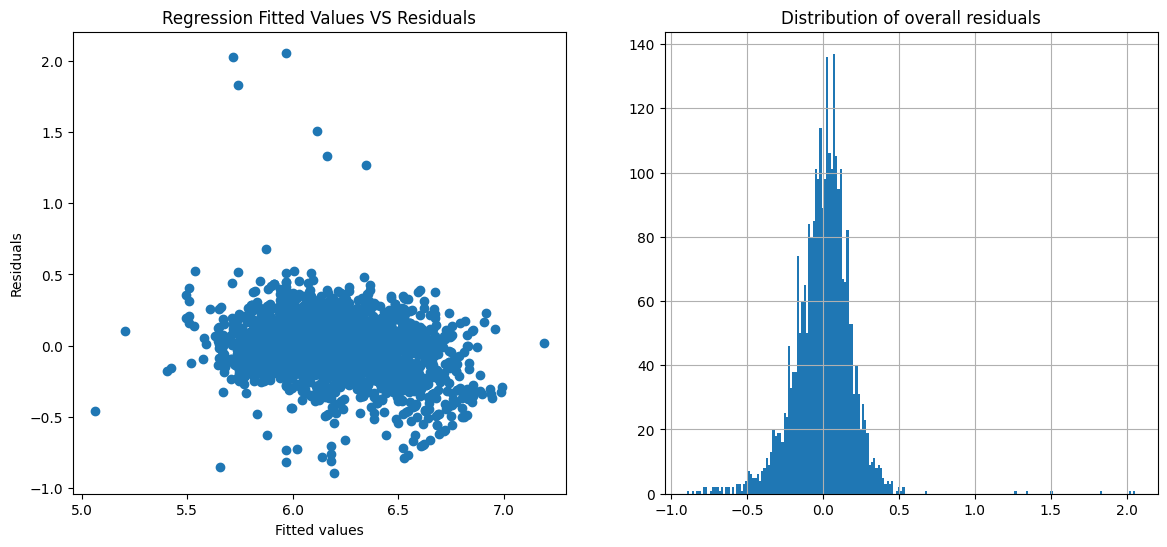

In [1708]:
residual_plot(best_model_choice_in_train_feat_eng_with_MAE['potentially_best_model_fitted'], 
              train_data_strat_preproc_feature_eng_1.drop(columns='cost_text').values, 
              train_data_strat_preproc_feature_eng_1['cost_text'])

count    2846.000000
mean        0.000620
std         0.209298
min        -1.237000
25%        -0.099000
50%         0.011000
75%         0.114000
max         2.283000
Name: cost_text, dtype: float64

{'fitted_vals': array([6.46215927, 6.0604585 , 6.55508348, ..., 6.18391603, 6.49668771,
        6.41750885]),
 'residuals': 0      -0.059934
 1      -0.102856
 5       0.040371
 8       0.067494
 9      -0.075966
           ...   
 5673   -0.161874
 5674   -0.233152
 5684    0.120131
 5687   -0.082564
 5689   -0.175536
 Name: cost_text, Length: 2846, dtype: float64}

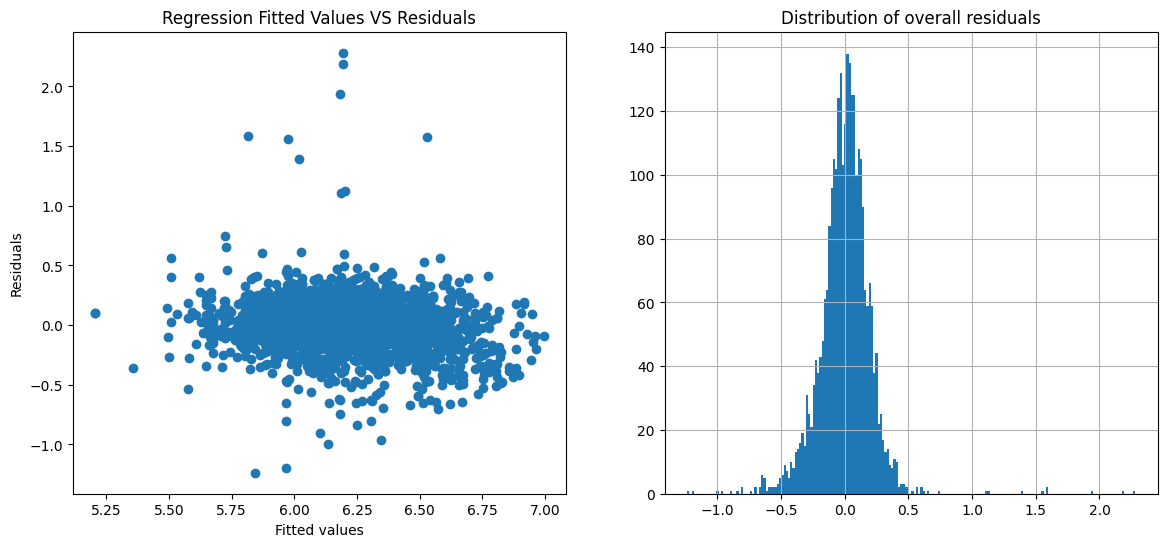

In [1276]:
residual_plot(best_model_choice_in_train_feat_eng_with_MAE['potentially_best_model'].fit(
    train_data_strat_preproc_feature_eng_1.drop(columns='cost_text').values,
    train_data_strat_preproc_feature_eng_1['cost_text']
), test_data_strat_preproc_feature_eng_1.drop(columns='cost_text').values, test_data_strat_preproc_feature_eng_1['cost_text'])

In [972]:
pd.DataFrame(
    
    index=['Intercept'] + list(train_data_strat_preproc_feature_eng_1.drop(columns='cost_text').columns), 
    
    data=[best_model_choice_in_train_feat_eng_with_MAE['potentially_best_model_fitted'].intercept_] +\
                list(best_model_choice_in_train_feat_eng_with_MAE['potentially_best_model_fitted'].coef_), 
    columns=['Coefficient (MAE)']
)

Coefficient (MAE)
Intercept                       6.240838
nearest_hospital                0.002338
nearest_train_station           0.004962
distance_to_cbd                 0.015771
nearest_school                  0.001274
...                                  ...
parking_spaces_2                0.045938
parking_spaces_3                0.055941
parking_spaces_4                0.053225
parking_spaces_5               -0.057342
parking_spaces_6               -0.006717

[263 rows x 1 columns]

In [973]:
pd.DataFrame(
    
    index=['Intercept'] + list(train_data_strat_preproc.drop(columns='cost_text').columns), 
    
    data=[best_model_choice_in_train_with_MAE['potentially_best_model_fitted'].intercept_] +\
                list(best_model_choice_in_train_with_MAE['potentially_best_model_fitted'].coef_), 
    columns=['Coefficient (MAE)']
)

Coefficient (MAE)
Intercept                     550.118845
nearest_hospital                0.654370
nearest_train_station           0.998467
distance_to_cbd                 1.950499
nearest_school                  0.156040
...                                  ...
parking_spaces_2               25.556933
parking_spaces_3               32.054212
parking_spaces_4               35.980444
parking_spaces_5              -11.727916
parking_spaces_6                7.636216

[269 rows x 1 columns]

# 4.5 Fit the same model above, but without the historical external variables <a name='bookmark4.5' />

<a href=#TOC>Back to ToC</a>

Feature engineering: 
- <code>dist_to_CBD = log(1/dist_to_cbd)</code>
- <code>cost_text = log(cost_text)</code>
- Remove all historical external variables

In [1709]:
train_data_strat_feat_eng_but_no_externals = feature_engineering_1(train_data_strat,with_external_vars=False)
train_data_strat_feat_eng_but_no_externals = train_data_strat_feat_eng_but_no_externals.loc[:,
                    ~train_data_strat_feat_eng_but_no_externals.columns.str.contains('\d')]

In [1710]:
train_data_strat_preproc_feature_eng_without_external_vars = preprocess_vars_for_train(
                            train_data_strat_feat_eng_but_no_externals)

best_model_choice_in_train_feat_eng_no_externals_with_MAE =\
        best_penalty_method_elastic_net(train_data_strat_preproc_feature_eng_without_external_vars,
                                      n_splits=10,
                                      scoring='mean_absolute_error',
                                      random_state=1)


In [1718]:
best_model_choice_in_train_feat_eng_no_externals_with_MAE['potentially_best_model']

ElasticNet(alpha=0.0, n_splits=0, random_state=1, scoring='mean_absolute_error')

In [1720]:
lambda_best_model_3 = best_model_choice_in_train_feat_eng_no_externals_with_MAE['potentially_best_model_fitted'].lambda_best_

In [1721]:
final_data_no_external_vars = feature_engineering_1(final_data, with_external_vars=False)
final_data_no_external_vars = final_data_no_external_vars.loc[:,~final_data_no_external_vars.columns.str.contains('\d')]

In [1724]:
k_fold_CV(final_data_no_external_vars, 
          7, 
          best_model_choice_in_train_feat_eng_no_externals_with_MAE['potentially_best_model'], 
          shuffle_data=False, 
          swap_train_test=False, 
          score='MAE',
          display_entropy_suburbs=True,
          lambda_best=lambda_best_model_3,
          retransform_log_y=True
         )

Scores for test folds:  [ -89.93625593  -89.78103097 -109.90293592 -108.2975827   -89.04255884
 -112.43861871  -96.91442911]
Suburb entropies for test folds:  [3.032525676520306, 3.023038641157015, 2.796573644347831, 2.5298961250058234, 2.7107580458181495, 2.885837288139622, 2.810444169200354]


Scores for training folds:  [-76.84245128 -77.93688067 -74.56474885 -74.65709728 -75.95552273
 -75.47868979 -75.72635534]
Suburb entropies for training folds:  [4.56067808061269, 4.568509558402692, 4.5998223744706195, 4.64470328482791, 4.611909119234889, 4.578844957805499, 4.592840587333945]


(array([ -89.93625593,  -89.78103097, -109.90293592, -108.2975827 ,
         -89.04255884, -112.43861871,  -96.91442911]),
 array([-76.84245128, -77.93688067, -74.56474885, -74.65709728,
        -75.95552273, -75.47868979, -75.72635534]))

In [1713]:
# hundred_fold_cv_no_external_vars = k_fold_CV(final_data_no_external_vars, 
#           100, 
#           best_model_choice_in_train_feat_eng_no_externals_with_MAE['potentially_best_model'], 
#           shuffle_data=False, 
#           swap_train_test=False, 
#           score='MAE',
#           display_entropy_suburbs=True)
# print(hundred_fold_cv_no_external_vars[0].mean(), hundred_fold_cv_no_external_vars[1].mean())

Scores for test folds:  [-104.93566355 -107.36087099  -98.81776413  -93.45625024 -111.79410082
  -93.15744877 -100.6079719   -98.36091151 -102.02580963  -99.8413837 ]
Suburb entropies for test folds:  [4.60024599491578, 4.652312002201747, 4.607686153752278, 4.656401263960024, 4.675924216578984, 4.656052045939247, 4.653665723389108, 4.660337596445223, 4.631001774181215, 4.63721564549957]


Scores for training folds:  [-83.48778348 -71.01094923 -74.11565071 -99.71527337 -97.75393556
 -92.31336274 -74.01788315 -91.41525438 -89.87673508 -87.90213315]
Suburb entropies for training folds:  [2.8249073282131185, 2.368842973358736, 2.783074064993785, 2.332108362404745, 2.213485880340812, 2.4607926138017806, 2.4496134783823122, 2.3599814249737734, 2.619592724518656, 2.524795880853646]
train_size for above: 569(10.0%)


Scores for test folds:  [-103.5839116  -104.69912721  -95.3793904  -100.21031285  -93.10297482
  -95.61348587  -99.3296662  -102.87476195  -97.15160461]
Suburb entropies for test 

Scores for test folds:  [ -88.09273351  -85.29897034  -95.85972321 -114.93232567 -112.67381582
  -97.74576877  -98.24598019  -95.92081619  -98.01572602]
Suburb entropies for test folds:  [2.88198164767555, 2.546349124051746, 2.7982139604464344, 2.530787041644524, 2.3054053827998304, 2.507358550885714, 2.639449196659877, 2.6721315051179637, 2.5909059557902006]


Scores for training folds:  [-76.96910377 -76.96820697 -76.2890122  -74.73711899 -74.33296558
 -75.52327227 -77.10907194 -75.05583506 -75.60195179]
Suburb entropies for training folds:  [4.58904839312107, 4.637233658141678, 4.605070079182064, 4.649722418079411, 4.678729185169007, 4.642059815728585, 4.635677065214773, 4.630822555879202, 4.6259921926461285]
train_size for above: 5057(88.89%)


Scores for test folds:  [ -89.47450718  -79.29096325  -92.44852355 -110.31896767 -114.26785792
 -106.20571564  -85.67896818 -122.98871386  -94.17711966  -97.46437611]
Suburb entropies for test folds:  [2.8249073282131185, 2.368842973358736, 

/tmp/ipykernel_870/3184143871.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  test_scores = np.array(test_scores)
/tmp/ipykernel_870/3184143871.py:64: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  train_scores = np.array(train_scores)


[array([-86.16089609, -85.41619462, -88.07421698, -88.17004008,
        -88.50828942, -90.32000382, -91.04924962, -91.66278925,
        -92.48719116, -75.73397882, -75.85858941, -75.85942582,
        -75.88171977, -75.88024942, -75.89715379, -75.84294873,
        -75.90827015]),
 array([-101.03581752,  -99.10502617,  -98.08632701,  -98.29735882,
         -99.37113914,  -98.25535795,  -97.38741682,  -95.47639832,
         -94.61281228, -100.3304396 , -100.08265975,  -99.48792189,
         -99.786975  ,  -99.4733446 ,  -99.3911799 ,  -98.53176219,
         -99.2315713 ])]

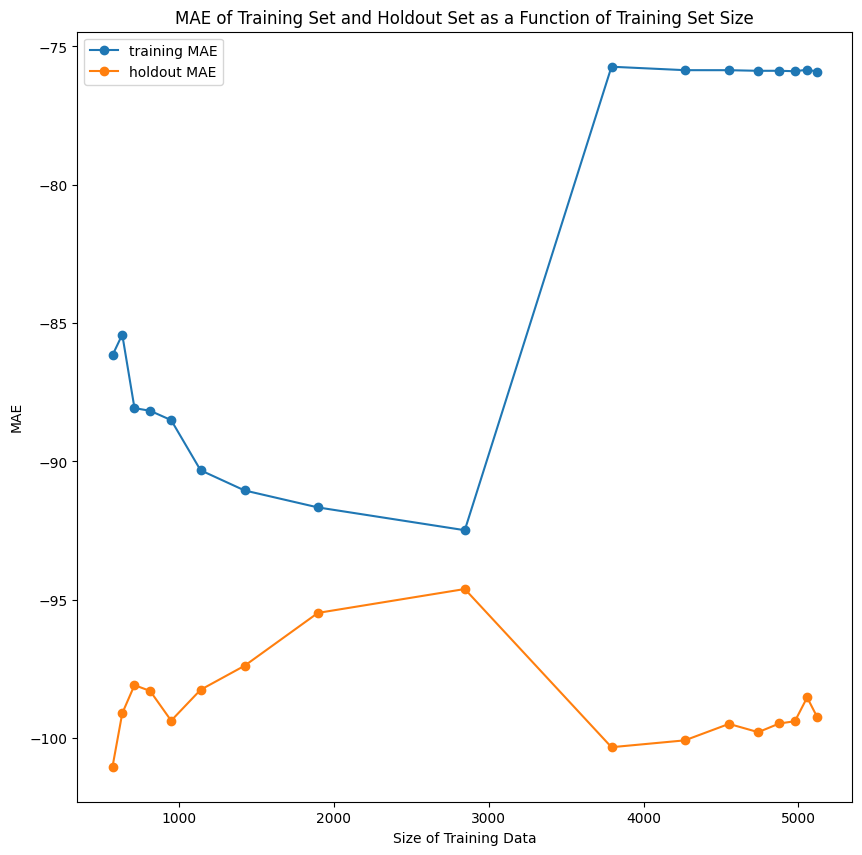

In [1725]:
plot_learning_curve(best_model_choice_in_train_feat_eng_no_externals_with_MAE['potentially_best_model'], 
                    final_data_no_external_vars, 
                    max_k=10, 
                    output=True, 
                    scoring='MAE',
                    display_entropy_suburbs=True,
                    retransform_log_y=True,
                    lambda_best=lambda_best_model_3
                    )

count    2844.000000
mean       -0.000002
std         0.195378
min        -0.905000
25%        -0.094000
50%         0.015000
75%         0.108250
max         2.037000
Name: cost_text, dtype: float64

{'fitted_vals': array([6.2139303 , 6.30541754, 6.2139533 , ..., 6.2221377 , 6.09093376,
        6.40330652]),
 'residuals': 3898   -0.182999
 3897   -0.004501
 3918    0.040167
 3933   -0.064972
 3912    0.012984
           ...   
 1886    0.201124
 1865   -0.171967
 1874   -0.174792
 1899   -0.162895
 1882   -0.140605
 Name: cost_text, Length: 2844, dtype: float64}

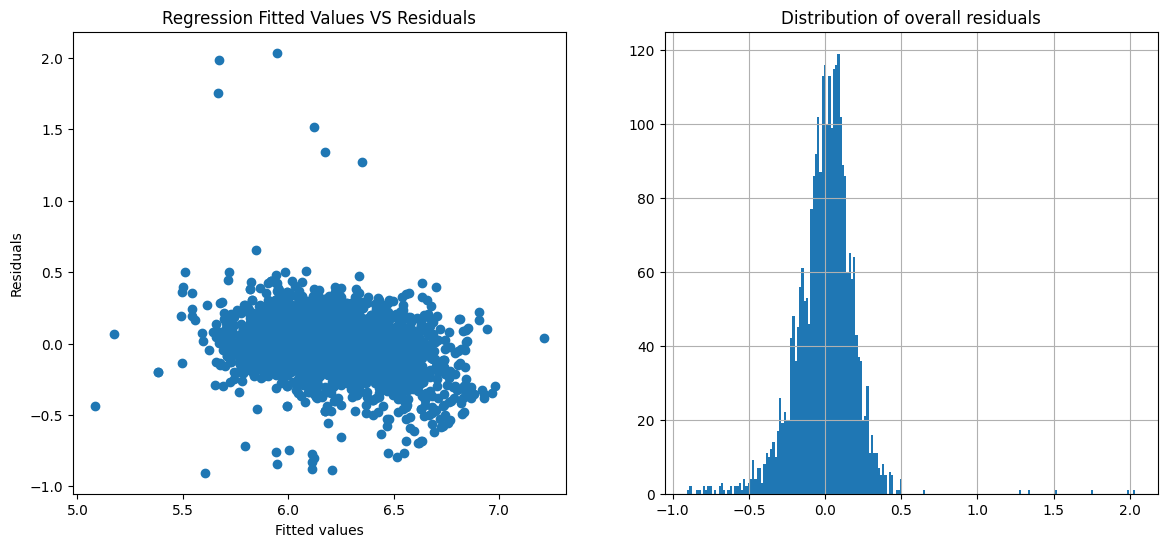

In [1726]:
residual_plot(best_model_choice_in_train_feat_eng_no_externals_with_MAE['potentially_best_model_fitted'], 
              train_data_strat_preproc_feature_eng_without_external_vars.drop(columns='cost_text').values, 
              train_data_strat_preproc_feature_eng_without_external_vars['cost_text'])

In [1200]:
best_model_choice_in_train_feat_eng_no_externals_with_MAE['potentially_best_model_fitted'].coef_

array([ 0.00704102,  0.00385169,  0.06220513, -0.00124973,  0.11158444,
        0.42863897, -0.25465602,  0.07403923, -0.10588919,  0.27825475,
       -0.05959767,  0.08479725, -0.15993856,  0.02722808, -0.04203375,
        0.25992279, -0.06408761, -0.05484445,  0.08952648,  0.08504759,
       -0.04538821, -0.02293418,  0.22895295,  0.16301642, -0.20523397,
        0.07400596, -0.00208363, -0.06886874, -0.19703492, -0.13339444,
       -0.01338066,  0.13337428,  0.16481691,  0.26269788,  0.00384843,
       -0.06880936, -0.14562955, -0.16278436,  0.03223327,  0.0037205 ,
       -0.05087248, -0.00462261, -0.05898163,  0.13268408, -0.18672211,
       -0.12338366, -0.15745371, -0.14589386, -0.20975315, -0.18057874,
       -0.02455107,  0.08135047,  0.04230833, -0.02405303,  0.0913898 ,
        0.06898026,  0.09343062, -0.00458637, -0.16036731,  0.24104287,
        0.07939574, -0.10881694, -0.23443038, -0.08056978,  0.07389987,
       -0.0605737 ,  0.0370129 , -0.0053374 , -0.24895974,  0.08

# Try to Increase Time Lag

In [1761]:
def temporary_pipeline_for_tuning_model_and_test_eval(train_data, test_data,
                             TIME_LAG=1,
                             encode_ordinal=True,
                             with_external_vars=True
                             ):
    
    train_data_for_fitting = train_data.copy()
    test_data_for_short_eval = test_data.copy()
    
    
    #feature engineering training data and preprocessing (standardize, OH-encode)
    
    #feat engs: standardization and retransforming external vars if needed
    train_data_feat_eng = feature_engineering_1(
                            train_data_for_fitting,
                            with_external_vars=with_external_vars,
                            TIME_LAG=TIME_LAG
                        )
    
    test_data_feat_eng = feature_engineering_1(
                        test_data_for_short_eval,
                        with_external_vars=with_external_vars,
                        TIME_LAG=TIME_LAG
                    )
    
    #preprocess the training and test dataset (OH encoder)
    train_data_feat_eng_and_preproc =\
            preprocess_vars_for_train(
        
                   train_data_feat_eng, 
                   encode_ordinal=encode_ordinal
            )
    
    test_data_feat_eng_and_preproc =\
            preproc_transform_test_data(
        
                    test_data_feat_eng,
                    train_data_feat_eng

            )
    
    

    #obtain optimal hyperparameters on the training data
    #(i.e. obtain optimal model)
    best_model_choice_and_hyps = best_penalty_method_elastic_net(
        train_data_feat_eng_and_preproc,
        n_splits=10,
        scoring='mean_absolute_error',
        random_state=1
    )
    
    lambda_best = best_model_choice_and_hyps['potentially_best_model_fitted'].lambda_best_[0]
    
    model_fit_no_reevaluation_of_lambda = best_model_choice_and_hyps['potentially_best_model'].\
            fit(train_data_feat_eng_and_preproc.drop(columns='cost_text').values,
                    train_data_feat_eng_and_preproc['cost_text'])
    
    print("Evaluation score for training data below (R2), using fitted model:")
    print(
        best_model_choice_and_hyps['potentially_best_model_fitted'].score(
            train_data_feat_eng_and_preproc.drop(columns='cost_text').values,
            train_data_feat_eng_and_preproc['cost_text']
        )
    )
    
    print("Evaluation score for training data below (R2), using model with specified lambda:")
    print(
        model_fit_no_reevaluation_of_lambda.\
            score(train_data_feat_eng_and_preproc.drop(columns='cost_text').values,
                  train_data_feat_eng_and_preproc['cost_text'],
                  lamb=lambda_best)
    )
    
    print("Evaluation score for test data below (R2), using fitted model:")
    print(
        best_model_choice_and_hyps['potentially_best_model_fitted'].score(
            test_data_feat_eng_and_preproc.drop(columns='cost_text').values,
            test_data_feat_eng_and_preproc['cost_text']
        )
    )
    
    print("Evaluation score for test data below (R2), using model with specified lambda:")
    print(
        model_fit_no_reevaluation_of_lambda.\
            score(test_data_feat_eng_and_preproc.drop(columns='cost_text').values,
                  test_data_feat_eng_and_preproc['cost_text'],
                  lamb=lambda_best)
    )
    
    
    return best_model_choice_and_hyps
    
    
    

In [1762]:
best_model_choice_2_year_lag = temporary_pipeline_for_tuning_model_and_test_eval(
                            train_data_strat, 
                            test_data_strat, TIME_LAG=2,
                             encode_ordinal=True,
                             with_external_vars=True
                             )

Evaluation score for training data below (R2), using fitted model:
0.6906689118495224
Evaluation score for training data below (R2), using model with specified lambda:
0.6906689118495224
Evaluation score for test data below (R2), using fitted model:
0.6906689118495224
Evaluation score for test data below (R2), using model with specified lambda:
0.6382365643746941


Scores for test folds:  [-101.66301605 -118.11915511  -95.68681033  -97.09133103  -92.35646552
 -115.16694066 -108.81146624  -92.55250567  -91.04299835 -102.38399176]


Scores for training folds:  [-62.06793847 -67.99401698 -62.09439203 -80.0214197  -90.13267703
 -75.8861167  -67.94557237 -81.14866996 -74.0454086  -75.42963889]
train_size for above: 569(10.0%)


Scores for test folds:  [-101.58664162  -97.09992596  -91.37483838  -92.12338885  -88.22412742
  -96.52667246  -97.52324105  -90.48626926 -103.24908597]


Scores for training folds:  [-62.9907969  -64.81365361 -70.81302717 -78.77869109 -83.30399168
 -75.86431085 -65.0183424  -81.87934013 -77.47696576]
train_size for above: 632(11.11%)


Scores for test folds:  [-101.65909801  -91.45475988  -91.00954013  -85.91885125 -118.8883473
 -110.05367548  -94.3782991   -99.40489828]


Scores for training folds:  [-66.86411209 -61.02688655 -80.56890361 -85.73894485 -76.56035857
 -64.05400247 -82.72703133 -76.84934115]
train_size for above:

/tmp/ipykernel_870/3184143871.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  test_scores = np.array(test_scores)
/tmp/ipykernel_870/3184143871.py:64: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  train_scores = np.array(train_scores)


[array([-73.67658507, -73.43767995, -74.29869758, -74.22747237,
        -75.05875604, -75.9164009 , -76.78996793, -77.2119361 ,
        -79.39323307, -75.60681465, -75.77963491, -75.79330756,
        -75.82493885, -75.82682324, -75.85229085, -75.79571033,
        -75.87008965]),
 array([-101.48746807,  -95.35491011,  -99.09593368,  -96.55047866,
         -94.99130366,  -94.7450686 ,  -95.16909243,  -89.77890325,
         -85.58277284,  -85.81083118,  -85.55673333,  -84.86982123,
         -85.62501894,  -85.63441282,  -85.45312458,  -85.09573084,
         -84.50977712])]

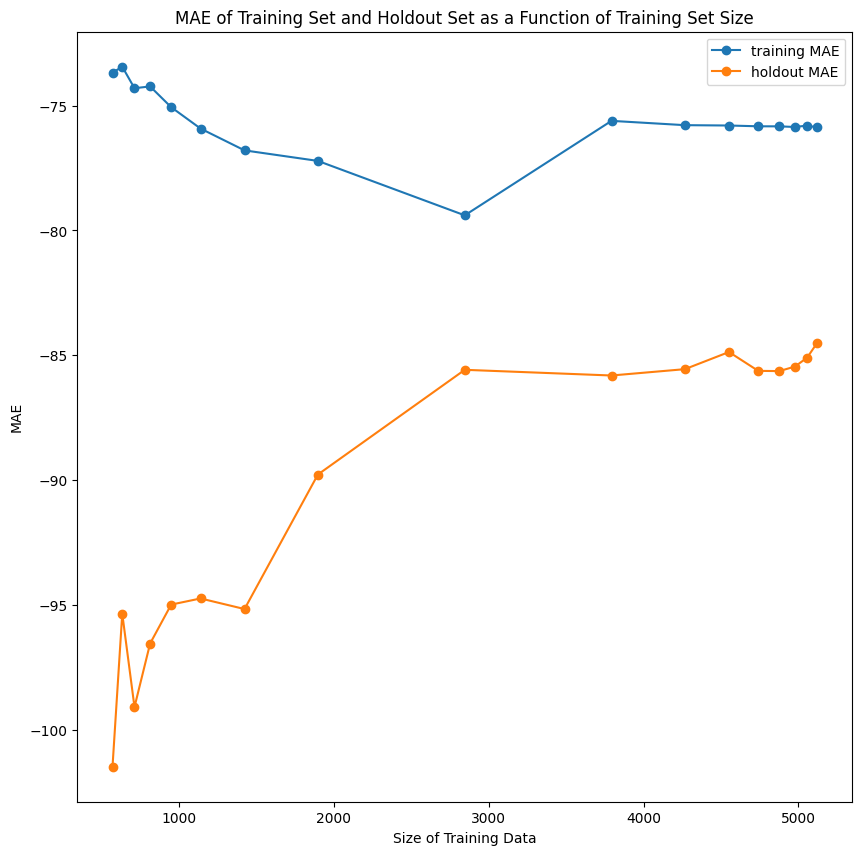

In [1770]:
plot_learning_curve(best_model_choice_2_year_lag['potentially_best_model'], 
                    feature_engineering_1(final_data, with_external_vars=True, TIME_LAG=3), 
                    max_k=10, 
                    output=True, 
                    scoring='MAE', 
                    display_entropy_suburbs=False, 
                    retransform_log_y=True,
                    lambda_best=best_model_choice_2_year_lag['potentially_best_model_fitted'].lambda_best_[0]
                   )

In [1771]:
best_model_choice_1_year_lag = temporary_pipeline_for_tuning_model_and_test_eval(
                            train_data_strat, 
                            test_data_strat, TIME_LAG=1,
                             encode_ordinal=True,
                             with_external_vars=True
                             )

Evaluation score for training data below (R2), using fitted model:
0.6902500562628607
Evaluation score for training data below (R2), using model with specified lambda:
0.6902500562628607
Evaluation score for test data below (R2), using fitted model:
0.6902500562628607
Evaluation score for test data below (R2), using model with specified lambda:
0.6375515931565185


In [1776]:
pd.DataFrame(
    
    index=['Intercept'] + list(test_data_strat_preproc_feature_eng_1.drop(columns='cost_text').columns), 
    
    data=[best_model_choice_1_year_lag['potentially_best_model_fitted'].intercept_] +\
                list(best_model_choice_1_year_lag['potentially_best_model_fitted'].coef_), 
    
    columns=['Coefficient (MAE)']
)

Coefficient (MAE)
Intercept                       6.240838
nearest_hospital                0.002338
nearest_train_station           0.004962
distance_to_cbd                 0.015771
nearest_school                  0.001274
...                                  ...
parking_spaces_2                0.045938
parking_spaces_3                0.055941
parking_spaces_4                0.053225
parking_spaces_5               -0.057342
parking_spaces_6               -0.006717

[263 rows x 1 columns]

# For the historical external variables, how bout we just use the 2021 features?

In [1778]:
final_data.columns[0:50]

Index(['cost_text', 'suburb', 'bedrooms', 'bathrooms', 'parking_spaces',
       'nearest_hospital', 'nearest_train_station', 'distance_to_cbd',
       'nearest_school', '2000_median_rent', '2001_median_rent',
       '2002_median_rent', '2003_median_rent', '2004_median_rent',
       '2005_median_rent', '2006_median_rent', '2007_median_rent',
       '2008_median_rent', '2009_median_rent', '2010_median_rent',
       '2011_median_rent', '2012_median_rent', '2013_median_rent',
       '2014_median_rent', '2015_median_rent', '2016_median_rent',
       '2017_median_rent', '2018_median_rent', '2019_median_rent',
       '2020_median_rent', '2021_median_rent', '2011_annual_income',
       '2012_annual_income', '2013_annual_income', '2014_annual_income',
       '2015_annual_income', '2016_annual_income', '2017_annual_income',
       '2018_annual_income', '2019_annual_income', '2020_annual_income',
       '2021_annual_income', 'population_2001', 'population_2002',
       'population_2003', 'populat

In [1779]:
final_data.columns[51:]

Index(['population_2010', 'population_2011', 'population_2012',
       'population_2013', 'population_2014', 'population_2015',
       'population_2016', 'population_2017', 'population_2018',
       'population_2019', 'population_2020', 'population_2021',
       'population_density_2001', 'population_density_2002',
       'population_density_2003', 'population_density_2004',
       'population_density_2005', 'population_density_2006',
       'population_density_2007', 'population_density_2008',
       'population_density_2009', 'population_density_2010',
       'population_density_2011', 'population_density_2012',
       'population_density_2013', 'population_density_2014',
       'population_density_2015', 'population_density_2016',
       'population_density_2017', 'population_density_2018',
       'population_density_2019', 'population_density_2020',
       'population_density_2021', '2016_immigration', '2017_immigration',
       '2018_immigration', '2019_immigration', '2020_immigra

# 4.6 Try OLS on <code>cost_text ~ all internal + proximity variables without historical external variables</code>

In [1494]:
train_data_preproc = preprocess_vars_for_train(train_data_strat, encode_ordinal=True)

train_data_preproc.loc[:,train_data_preproc.dtypes == 'uint8'] =\
        train_data_preproc.loc[:,train_data_preproc.dtypes == 'uint8'].astype('float64')


first_ols_model_all_vars = ols(
        formula = make_formula_object(
            
            train_data_preproc, 
            variables='all', 
            response='cost_text'
        ), 
    
    data = train_data_preproc
).fit()

In [1495]:
first_ols_model_all_vars.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              cost_text   R-squared:                       0.681
Model:                            OLS   Adj. R-squared:                  0.659
Method:                 Least Squares   F-statistic:                     30.84
Date:                Tue, 04 Oct 2022   Prob (F-statistic):               0.00
Time:                        15:05:49   Log-Likelihood:                -17552.
No. Observations:                2844   AIC:                         3.547e+04
Df Residuals:                    2659   BIC:                         3.658e+04
Df Model:                         184                                         
Covariance Type:            nonrobust                                         
=================================================================================================
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept                       428.3580     15.569     27.513      0.000     397.829     458.887
nearest_hospital                -27.9171     20.592     -1.356      0.175     -68.296      12.461
nearest_train_station             1.3485     24.821      0.054      0.957     -47.323      50.020
distance_to_cbd                 -39.3302    120.437     -0.327      0.744    -275.489     196.829
nearest_school                   -0.1579      3.261     -0.048      0.961      -6.552       6.236
Q("2000_median_rent")           110.4006    208.331      0.530      0.596    -298.107     518.909
Q("2001_median_rent")          -170.3585    243.900     -0.698      0.485    -648.611     307.894
Q("2002_median_rent")            78.4836    142.307      0.552      0.581    -200.560     357.527
Q("2003_median_rent")           -45.6833    113.610     -0.402      0.688    -268.457     177.090
Q("2004_median_rent")           -79.8935    146.213     -0.546      0.585    -366.596     206.809
Q("2005_median_rent")             4.1162    146.446      0.028      0.978    -283.044     291.277
Q("2006_median_rent")            -1.1175    155.588     -0.007      0.994    -306.203     303.968
Q("2007_median_rent")            58.2346    130.000      0.448      0.654    -196.676     313.145
Q("2008_median_rent")          -146.5570    269.888     -0.543      0.587    -675.769     382.655
Q("2009_median_rent")            92.9023    184.774      0.503      0.615    -269.414     455.218
Q("2010_median_rent")           -16.7157    125.933     -0.133      0.894    -263.653     230.221
Q("2011_median_rent")            30.9524    101.227      0.306      0.760    -167.540     229.444
Q("2012_median_rent")            23.5656     98.826      0.238      0.812    -170.218     217.349
Q("2013_median_rent")          -232.6891    335.344     -0.694      0.488    -890.251     424.872
Q("2014_median_rent")           195.7684    195.266      1.003      0.316    -187.119     578.656
Q("2015_median_rent")             8.7549    159.259      0.055      0.956    -303.530     321.039
Q("2016_median_rent")           -14.2539     79.111     -0.180      0.857    -169.378     140.871
Q("2017_median_rent")            24.2987    118.085      0.206      0.837    -207.248     255.846
Q("2018_median_rent")            30.9774    102.146      0.303      0.762    -169.316     231.270
Q("2019_median_rent")           -52.7732    285.839     -0.185      0.854    -613.263     507.717
Q("2020_median_rent")            98.0213    201.269      0.487      0.626    -296.639     492.682
Q("2021_median_rent")           -11.8238     67.692     -0.175      0.861    -144.557     120.910
Q("2011_annual_income")          75.5936     85.005      0.889      0.374     -91.089     242.276
Q("2012_annual_income")          31.0669     

In [1491]:
test_data_preproc = preproc_transform_test_data(test_data_strat, train_data_strat)

In [1492]:
first_ols_model_all_vars.predict(test_data_preproc)

0       636.416088
1       384.730542
5       737.976271
8       722.704424
9       723.676276
           ...    
5673    712.748341
5674    581.454431
5684    472.219899
5687    712.440742
5689    622.861007
Length: 2846, dtype: float64

<font color='blue'>Function: K-fold CV for OLS</font>

In [1496]:
def k_fold_CV_OLS(data, k, shuffle_data=False, 
                  swap_train_test=False, score='MAE', variables='all'):
    
    """Performs a K-fold cross validation
    model evaluation technique on 'data', and
    returns the scores (R2 or MAE)
    In particular, return value is:
    (testing_scores, training_scores)
    
    Each is a list. 

    
    """
    
    N = data.shape[0]
    N_per_fold = N // k
    
    scores_per_test_fold = []
    training_scores_per_iteration = []
    
    if shuffle_data == True:
        #add code for random permutation if needed.
        #but for now we dont really need it. 
        pass
    
    for fold in range(0,k):
        #obtain testing and training folds
        testing_fold = data.iloc[ (N//k) * fold: (N//k) * (fold+1) ]
        training_folds = data[~data.index.isin(testing_fold.index)]
        
        #preprocess training and testing folds
        
        if swap_train_test == False: #usual K-fold CV (one fold = testing)
            
            training_folds_preproc = preprocess_vars_for_train(training_folds, encode_ordinal=True)
            testing_folds_preproc = preproc_transform_test_data(testing_fold, training_folds)
            
            
        else:    
            
            testing_folds_preproc = preprocess_vars_for_train(training_folds, encode_ordinal=True)
            training_folds_preproc = preproc_transform_test_data(testing_fold, training_folds)
        
        
        #train the model on the current training folds
        model = ols(
            formula = make_formula_object(

                    training_folds_preproc, 
                    variables=variables, 
                    response='cost_text'
                ), 
    
            data = training_folds_preproc
        )
        
        model_fitted = model.fit()
        
            
        if score == 'MAE':
            
            #note: since MAE represents the DEVIATIONS between predicted
            #and actual value one way to inverse it is to multiply by -1
            
            #i. get testing prediction, and evaluate mean absolute error
            predict_test = model_fitted.predict(
                testing_folds_preproc
            )
            
            score_per_test_fold = testing_folds_preproc['cost_text'] - predict_test
            score_per_test_fold = -1 * np.mean(abs(score_per_test_fold))
            
            #ii. get training prediction (i.e. fitted values), and evaluate mean absolute error
            predict_train = model_fitted.predict(
                training_folds_preproc
            )
            
            training_score_per_iteration = training_folds_preproc['cost_text'] - predict_train
            training_score_per_iteration = -1 * np.mean(abs(training_score_per_iteration))

        scores_per_test_fold.append(score_per_test_fold)
        training_scores_per_iteration.append(training_score_per_iteration)
        
    scores_per_test_fold = np.array(scores_per_test_fold)
    training_scores_per_iteration = np.array(training_scores_per_iteration)
    
    print("Scores for test folds: ", scores_per_test_fold)    
    print("Scores for training folds: ", training_scores_per_iteration)
    
    return scores_per_test_fold, training_scores_per_iteration


In [1507]:
k_fold_CV_OLS(final_data, 
              10, 
              shuffle_data=False, 
              swap_train_test=False, 
              score='MAE', 
              variables='all'
             )

Scores for test folds:  [ -87.06538264 -116.77656539  -90.09831634  -97.43637853 -143.34890829
 -126.03501155  -86.4701354  -113.39020838 -100.59580794 -102.86342118]
Scores for training folds:  [-81.94034135 -81.87481903 -82.04220479 -79.9227354  -79.21341765
 -80.3471361  -81.62983035 -79.47709459 -80.59621414 -80.29899638]


(array([ -87.06538264, -116.77656539,  -90.09831634,  -97.43637853,
        -143.34890829, -126.03501155,  -86.4701354 , -113.39020838,
        -100.59580794, -102.86342118]),
 array([-81.94034135, -81.87481903, -82.04220479, -79.9227354 ,
        -79.21341765, -80.3471361 , -81.62983035, -79.47709459,
        -80.59621414, -80.29899638]))

In [1509]:
np.mean(np.array([-81.94034135, -81.87481903, -82.04220479, -79.9227354 ,
        -79.21341765, -80.3471361 , -81.62983035, -79.47709459,
        -80.59621414, -80.29899638]))

-80.73427897799999

In [1504]:
def plot_learning_curve_OLS(data, max_k=3, output=True, scoring='MAE', variables='all'):
    
    train_scores = []
    test_scores = []
    train_sizes = []
    
    N = data.shape[0]
    
    k_values = list(range(2, max_k+1))
    
    for k in k_values[::-1]: #k_values: max_k, decrease to 2
        
        k_fold_scores =\
            k_fold_CV_OLS(data,
            k, 
            shuffle_data=False,
            swap_train_test=True,
            score=scoring,
            variables=variables)
        
        train_scores.append( k_fold_scores[1] )
        test_scores.append( k_fold_scores[0] )
        
        train_sizes.append( 
            int( N * (1/k) )
        )
        
        print(f'train_size for above: {int( N * (1/k) )}({round(100*1/k,2)}%)')
        print('\n')
        
    for k in k_values[1:]: #k_values: 3, increase to max_k
        
        #the number of folds k in k-fold will
        #depend on the train sizes used for the
        #training folds
        
        k_fold_scores =\
            k_fold_CV_OLS(data,
            k, 
            shuffle_data=False,
            swap_train_test=False,
            score=scoring,
            variables=variables)
        
        train_scores.append( k_fold_scores[1] ) 
        test_scores.append( k_fold_scores[0]) 
        
        train_sizes.append( 
            int( N * ((k-1)/k) )
        )
        
        print(f'train_size for above: {int( N * ((k-1)/k) )}({round(100*((k-1)/k),2)}%)')
        print('\n')
    
    test_scores = np.array(test_scores)
    train_scores = np.array(train_scores)
    
    if output:
        print("train set sizes, training set scores, testing set scores below:\n")
        print(train_sizes, train_scores[0:5], '\n\n', test_scores[0:5])
    
    
    #using np.vectorise preceding
    #np.mean: cant find a way to reshape np arrays so that it won't throw errors
    #otherwise numpys a bit pedantic to not simply able to take means of rows..
    
    
    plt.figure(figsize=(10,10))
    plt.title(f'{scoring} of Training Set and Holdout Set as a Function of Training Set Size')
    plt.plot(train_sizes, np.vectorize(np.mean)(train_scores),label='line with marker',marker='o')
    plt.plot(train_sizes, np.vectorize(np.mean)(test_scores),label='line with marker',marker='o')
    plt.xlabel('Size of Training Data')
    plt.ylabel(f'{scoring}')
    plt.legend([f'training {scoring}', f'holdout {scoring}'])
    
    return [np.vectorize(np.mean)(train_scores), np.vectorize(np.mean)(test_scores)]

Scores for test folds:  [ -374.3479642   -337.31343162 -1183.47865884 -1460.44275992
  -329.66353725  -550.554822    -834.14772025  -844.26469261
  -942.66276422 -2170.05433806 -1155.11488672  -490.98649932
  -570.26953008  -335.56364477  -529.32495106  -641.69803002
  -217.99428527  -364.15821339  -763.9237501   -274.51079992]
Scores for training folds:  [ -54.43446954  -64.41300922  -68.88883912  -57.64166188  -51.02873617
  -74.91463746  -85.02159511  -77.69538536  -79.25212173  -91.67776671
  -79.46862345  -79.7242172   -76.96214975  -53.83714403  -66.15582711
 -108.90832776  -72.7989169   -79.8574344   -85.37178312  -74.50574424]
train_size for above: 284(5.0%)


Scores for test folds:  [ -370.44199815  -360.16056587  -737.46213823  -485.13173152
  -285.01987046  -803.39471435  -771.94260784  -774.29390854
  -609.89885317 -1334.0017337   -256.29296191  -520.65807903
  -447.32530811  -976.97679621  -318.58017856  -402.73736478
  -373.53695155  -836.55995659  -277.69221652]
Scores f

Scores for test folds:  [ -87.05045232 -108.31758443 -121.97092459 -130.45151481 -106.00274078
 -113.14302741]
Scores for training folds:  [-82.41552068 -82.41180107 -78.66062497 -80.15545114 -80.62270389
 -79.82555474]
train_size for above: 4741(83.33%)


Scores for test folds:  [ -87.38124101 -105.12491766  -93.88547376 -166.46693731  -97.12266292
 -114.37816198 -108.02723261]
Scores for training folds:  [-82.05595865 -82.90433273 -79.71291506 -79.74913406 -80.85170533
 -79.4887747  -80.02002573]
train_size for above: 4877(85.71%)


Scores for test folds:  [ -86.95221711 -109.40070348 -107.86334275 -135.03105906 -118.26054797
  -94.8610286  -125.160452   -114.41685091]
Scores for training folds:  [-81.98345571 -83.12638651 -79.67325469 -79.47595477 -80.11771373
 -82.34804781 -79.12770398 -79.92083619]
train_size for above: 4978(87.5%)


Scores for test folds:  [ -85.20591988 -113.78627083 -102.91950632 -101.68476428 -135.39591617
 -103.73423298 -106.1453295   -98.17592545 -106.726508

/tmp/ipykernel_870/3933675385.py:55: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  test_scores = np.array(test_scores)
/tmp/ipykernel_870/3933675385.py:56: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  train_scores = np.array(train_scores)


[array([-74.12791951, -74.24805384, -74.40541857, -75.35679769,
        -75.69133294, -75.37623555, -75.83428981, -75.76824895,
        -76.69114145, -76.46314005, -77.75653903, -77.17292551,
        -78.39411347, -77.7526428 , -78.36146649, -79.63690875,
        -79.81999669, -79.66500248, -80.62874689, -80.48157312,
        -80.66599516, -80.71595494, -80.68194275, -80.68326375,
        -80.72166917, -80.67090864, -80.73427898, -80.7195022 ,
        -80.73265824, -80.71477087, -80.72621017, -80.73992749,
        -80.74251944, -80.74273895, -80.72675288, -80.73993197,
        -80.74722956]),
 array([-718.52376398, -575.90041764, -583.7556558 , -528.41673314,
        -534.94486094, -569.10196333, -515.54359565, -404.95458638,
        -481.27799715, -433.03044167, -349.48312544, -388.56053142,
        -341.61218589, -301.1928235 , -354.37514217, -218.42180952,
        -387.13299486, -324.40601482, -675.75378423, -118.28075461,
        -123.84187156, -112.71899501, -111.15604072, -110.34

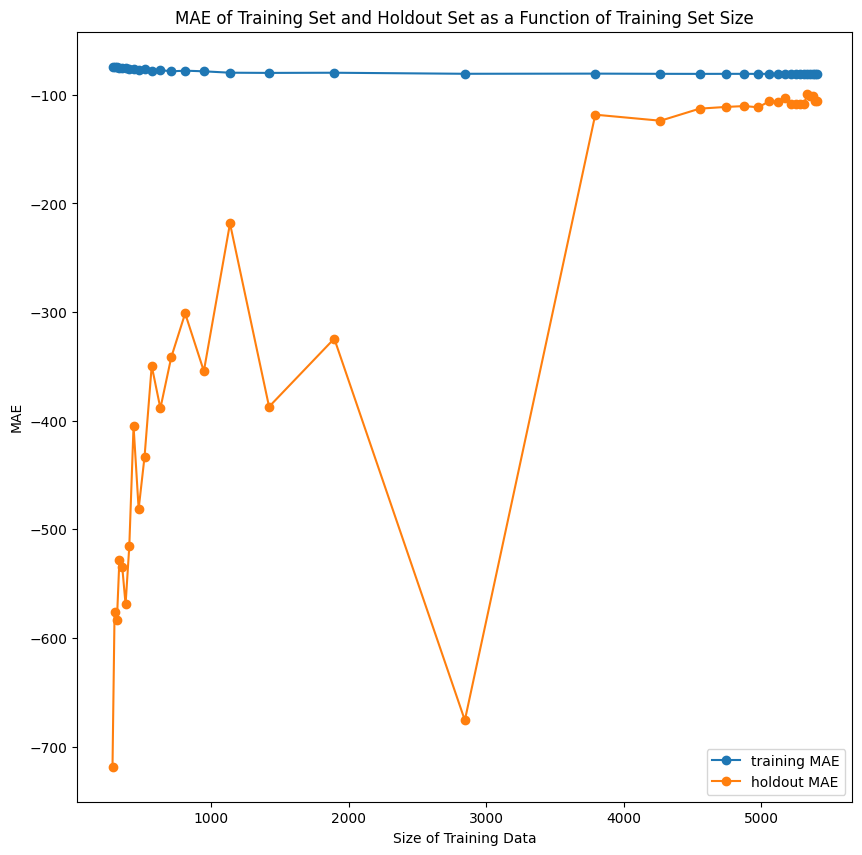

In [1510]:
plot_learning_curve_OLS(final_data, max_k=20, output=True, scoring='MAE', variables='all')